# Import Necessary Library

In [1]:
import numpy as np # for numerical operations
import pandas as pd # for data manipulation and analysis
import yfinance as yf # for downloading stock data
import tensorflow as tf # for GPU support
from sklearn.preprocessing import StandardScaler # for scaling the data
from tensorflow.keras.models import Sequential # for building the model
from keras.layers import CuDNNLSTM # for LSTM layers
from tensorflow.keras.layers import Dense, Dropout # for fully connected layers and dropout
from tensorflow.keras.callbacks import EarlyStopping # for early stopping during training
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score # for evaluation metrics
import matplotlib.pyplot as plt # for plotting

# Download and Preprocess Data

In [2]:
def download_data(ticker, start_date=None, end_date=None):
    """
    Download historical stock data from Yahoo Finance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data_drop_level = data.droplevel(1, axis=1)
    data_round = data_drop_level.round(6)
    return data_round

def normalize_data(data):
    """
    Normalize the data by deducting mean and divided by standard deviation.
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    return data_scaled, scaler

def create_windows(data, window_size, horizon=1):
    """
    Split time-series data into input windows and target windows.
    - data: 1D array of transformed log returns.
    - window_size: Number of past time steps to use as input.
    - horizon: Number of future time steps to predict.
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon])
    X, y = np.array(X), np.array(y)
    return X, y

# Define function for Fitting Quality

In [3]:
def calculate_volatility(data, window=20):
    """"
    The volatility is calculated as the median of the rolling standard deviation of the closing prices.
    """
    if isinstance(data, pd.Series):
        data = data['Close']
    df = pd.Series(data)
    volatility = df.rolling(window=window).std()
    volatility_median = volatility.median() 
    standardized_volatility_median = volatility_median / df.median()
    return standardized_volatility_median

def calculate_baseline_loss(X_train, y_train):
    """
    Calculate the baseline loss using the last observed value as the prediction.
    """
    y_train_pred = X_train[:, -1]  # Use the last observed value as the prediction
    baseline_loss = mean_squared_error(y_train, y_train_pred)
    return baseline_loss

def fitting_multiplier(data_volatility, baseline_volatility, alpha=0.8, beta=1.2):
    """
    Calculate underfitting and overfitting multipliers based on volatility.
    - alpha: Underfitting multiplier (default: 0.8).
    - beta: Overfitting multiplier (default: 1.2).
    """
    ratio = data_volatility / baseline_volatility
    underfit_multiplier = alpha * ratio
    overfit_multiplier = beta * ratio
    return underfit_multiplier, overfit_multiplier

def fitting_threshold(train_loss, baseline_loss, underfit_multiplier, overfit_multiplier):
    """"
    Calculate underfitting and overfitting thresholds based on training and baseline losses.

    """
    underfit_threshold = baseline_loss * underfit_multiplier
    overfit_threshold = train_loss * overfit_multiplier
    return underfit_threshold, overfit_threshold

def check_fitting(train_loss, val_loss, underfit_threshold, overfit_threshold):
    """
    Check for underfitting and overfitting based on dynamic thresholds.
    
    """
    if train_loss > underfit_threshold:
        return "underfitting"
    elif val_loss > overfit_threshold:
        return "overfitting"
    else:
        return "well-fitted"

# Define LSTM Model

In [4]:
def build_lstm_aro_model(input_shape, x0, x1, x2, x3, x4, x5, x6, optimizer, learning_rate):
    """
    Build an LSTM model with the specified hyperparameters.
    """
    print("below is the input shape and hyperparameters for the model")
    # Print the input shape
    print(f'input shape: ', input_shape)
    # Print the hyperparameters
    print(f"hyperparameters: {'{'}'x0': {x0}, 'x1': {x1}, 'x2': {x2}, 'x3': {x3}, 'x4': {x4}, 'x5': {x5}, 'x6': {x6}, 'optimizer': '{optimizer}', 'learning_rate': {learning_rate}{'}'}")
    
    input = [tf.keras.Input(shape=input_shape)]
    # print(input)
    model = Sequential(input)
    # print('model is created')
    
    # Input layer
    model.add(CuDNNLSTM(units=x0, return_sequences=bool(x1 + x3 >= 1)))
    # print('input layer is added')

    # Second LSTM layer (if x1 == 1)
    if x1 == 1:
        model.add(CuDNNLSTM(units=x2, return_sequences=bool(x3 == 1)))
        # print('second layer is added')

    # Third LSTM layer (if x3 == 1)
    if x3 == 1:
        model.add(CuDNNLSTM(units=x4, return_sequences=False))
        # print('third layer is added')

    # Dense layer
    model.add(Dense(units=x5, activation='relu'))
    # print('dense layer is added')

    # Dropout layer
    model.add(Dropout(rate=x6))
    # print('dropout layer is added')
    
    # Output layer
    model.add(Dense(units=1))
    # print('output layer is added')

    # Compile the model
    optimizer_instance = tf.keras.optimizers.get({
        'class_name': optimizer,
        'config': {'learning_rate': learning_rate}
    })
    # print('optimizer is created')
    model.compile(optimizer=optimizer_instance, loss='mean_squared_error')
    # print('model is compiled')

    return model

# Monitor Model Training

In [5]:
def plot_model_loss(history, window_size, order_of_split=None):
    """
    Plot the training and validation loss over epochs.
    """
    if order_of_split is not None:
        fold_string = f" (Fold of {order_of_split})"
    else:
        fold_string = ""    

    # Plot the training and validation loss

    ylim_max = round(np.ceil(max(history.history['val_loss'] + history.history['loss']) / 0.1) * 0.1, 2)
    xlim_max = int(np.ceil(len(history.history['loss']) / 5) * 5)

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(history.history['loss'], marker='o', c='blue', markeredgecolor='green', alpha=0.9)
    ax.plot(history.history['val_loss'], marker='o', c='red', markeredgecolor='grey', alpha=0.9)
    ax.set_title(f'Model Loss in window size of {window_size}' + fold_string)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(range(0, xlim_max + 5, 5))
    ax.set_xticks(range(0, xlim_max + 5, 1), minor=True)  # Minor ticks
    ax.set_yticks(np.arange(0, ylim_max + 0.1, 0.1))
    ax.set_yticks(np.arange(0, ylim_max + 0.1, 0.05), minor=True)  # Minor ticks
    ax.set_xlim(0, xlim_max)
    ax.set_ylim(0, ylim_max)
    ax.legend(['Training', 'Validation'], loc='upper right')
    ax.grid(which='both')
    plt.show()


def plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, window_size, order_of_split=None):
    """
    Plot the actual vs predicted values for training and testing sets.
    """
    if order_of_split is not None:
        fold_string = f" (Fold of {order_of_split})"
    else:
        fold_string = ""
    
    # Plot the actual vs predicted values
    actual = np.append(y_train, y_test)
    lim_min = np.floor((actual.min()) / 0.5) * 0.5
    lim_max = np.ceil((actual.max()) / 0.5) * 0.5

    fig, ax = plt.subplots(figsize=(8, 8))    
    ax.scatter(y_train, y_train_pred, label='Training Predictions', c='blue', edgecolors='green',alpha=0.9)
    ax.scatter(y_test, y_test_pred, label='Test Predictions', c='red', edgecolors='grey', alpha=0.9)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='black', linestyle='--', linewidth=1)
    ax.set_title(f'Actual vs Predicted Values in window size of {window_size}' + fold_string)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_xticks(np.arange(lim_min, lim_max + 0.5, 0.5))
    ax.set_xticks(np.arange(lim_min, lim_max + 0.5, 0.1), minor=True)    # Minor ticks
    ax.set_yticks(np.arange(lim_min, lim_max + 0.5, 0.5))
    ax.set_yticks(np.arange(lim_min, lim_max + 0.5, 0.1), minor=True)    # Minor ticks
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.grid(which='both')
    ax.legend(['Training', 'Testing', 'Line of 1:1'], loc='upper left')
    plt.show()

# Train and Evaluate Model

In [6]:
def model_build_fit_evaluate(input_shape, new_hyperparams, X_train, y_train, X_test, y_test):
    """
    Build, fit, and evaluate the LSTM model with the given hyperparameters.
    """
    # Evaluate the new solution
    model = build_lstm_aro_model(input_shape=input_shape, **new_hyperparams)
    # print("model is built")

    history = model.fit(X_train, y_train,
        epochs=100,
        batch_size=256,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )

    # Evaluate on training, validation, and test sets
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    val_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train Loss: {train_loss}, Val Loss: {val_loss}")
    
    return train_loss, val_loss, model, history

In [7]:
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, window_size, order_of_split=None):
    """
    Train and evaluate the LSTM model with the given hyperparameters.
    """
    # check if hyperparams is none
    if hyperparams is None:
        return None

    # Build, fit, and evaluate the model
    train_loss, val_loss, model, history = model_build_fit_evaluate((X_train.shape[1], 1), hyperparams, X_train, y_train, X_test, y_test)

    # Compare predictions vs actual values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Plot the training and validation loss
    plot_model_loss(history, window_size, order_of_split)

    # Plot the actual vs predicted values
    plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, window_size, order_of_split)

    return model, history, train_loss, val_loss, y_train_pred, y_test_pred


# Preprocess for Artificial Rabbits Optimization (ARO)

In [8]:
def initial_population(population_size=5, 
                       x0=(1, 21), 
                       x1=(0, 1), 
                       x2=(1, 21), 
                       x3=(0, 1), 
                       x4=(1, 21), 
                       x5=(1, 21), 
                       x6=(0.3, 0.4, 0.5, 0.6, 0.7), 
                       optimizer=('Adagrad', 'Adam', 'Adamax', 'RMSprop', 'SGD'), 
                       learning_rate=(0.01, 0.001, 0.0001, 0.00001, 0.000001)):
    """
    Create an initial population of hyperparameters.
    """
    population = [
        {
            'x0': np.random.randint(*x0),  # Neurons in the first LSTM layer
            'x1': int(temp1:=np.random.choice([*x1])),  # Whether the second LSTM layer exists
            'x2': np.random.randint(*x2) if temp1 == 1 else 0,  # Neurons in the second LSTM layer
            'x3': int(temp3:=np.random.choice([*x3])),  # Whether the third LSTM layer exists
            'x4': np.random.randint(*x4) if temp3 == 1 else 0,  # Neurons in the third LSTM layer
            'x5': np.random.randint(*x5),  # Neurons in the dense layer
            'x6': np.random.choice([*x6]),  # Dropout rate
            'optimizer': np.random.choice([*optimizer]),  # Optimizer
            'learning_rate': np.random.choice([*learning_rate])  # Learning rate
        }
        for _ in range(population_size)
    ]
    return population

def mutate_population(best_hyperparams, energy):
    """
    Mutate the hyperparameters based on the best hyperparameters and energy level.
    """
    # Update the hyperparameters based on the energy level    
    if energy > 1 :
        new_hyperparams = {
            'x0': np.clip(int(best_hyperparams['x0']) + np.random.randint(-5, 5), 1, 20),
            'x1': int(x1:=np.random.choice([0, 1])),
            'x2': np.clip(int(best_hyperparams['x2']) + np.random.randint(-5, 5), 1, 20) if x1 == 1 else 0,
            'x3': int(x3:=np.random.choice([0, 1])),
            'x4': np.clip(int(best_hyperparams['x4']) + np.random.randint(-5, 5), 1, 20) if x3 == 1 else 0,
            'x5': np.clip(int(best_hyperparams['x5']) + np.random.randint(-5, 5), 1, 20),
            'x6': np.clip(float(best_hyperparams['x6']) + np.random.uniform(-0.1, 0.1), 0.3, 0.7),
            'optimizer': np.random.choice(['Adagrad', 'Adam', 'Adamax', 'RMSprop', 'SGD']),
            'learning_rate': np.random.choice([0.01, 0.001, 0.0001, 0.00001, 0.000001])
            }
    else:
        new_hyperparams = {
            'x0': np.clip(int(best_hyperparams['x0']) + np.random.randint(-2, 2), 1, 20),
            'x1': int(x1:=best_hyperparams['x1']),
            'x2': np.clip(int(best_hyperparams['x2']) + np.random.randint(-2, 2), 1, 20) if x1 == 1 else 0,
            'x3': int(x3:=best_hyperparams['x3']),
            'x4': np.clip(int(best_hyperparams['x4']) + np.random.randint(-2, 2), 1, 20) if x3 == 1 else 0,
            'x5': np.clip(int(best_hyperparams['x5']) + np.random.randint(-2, 2), 1, 20),
            'x6': np.clip(float(best_hyperparams['x6']) + np.random.uniform(-0.05, 0.05), 0.3, 0.7),
            'optimizer': best_hyperparams['optimizer'],
            'learning_rate': best_hyperparams['learning_rate']
            }
        
    return new_hyperparams

In [9]:
def load_best_hyperparameters_record(csv, window_size):
    """
    Load the best hyperparameters record from a CSV file.
    """
    try :
        record = pd.read_csv(csv, index_col=0, parse_dates=['time_stamp'])
    except:        
        best_hyperparams = None
        best_loss = float('inf')
        print('no csv of best hyperparameters record are found')
    else:
        print('csv of best hyperparameters record is found')
        try:
            record_window = record.loc[window_size]
        except:            
            best_hyperparams = None
            best_loss = float('inf')
            print(f'window size of {window_size} is not found')
        else:
            print(f'window size of {window_size} is found')
            if isinstance(record_window, pd.DataFrame):
                print(f'record window is DataFrame')
                if len(valid_record := record_window[record_window['best_loss'] != float('inf')]) > 0:
                    last_record = valid_record.sort_values("time_stamp", ascending=False).iloc[0]
                    best_loss = last_record['best_loss']
                    best_hyperparams = last_record.loc['x0':'learning_rate'].to_dict()
                    print(f'non inf loss is found')
                else:
                    best_loss = float('inf')
                    best_hyperparams = None
                    print(f'inf loss is found')
            elif isinstance(record_window, pd.Series):
                print(f'record window is Series')
                if record_window['best_loss'] != float('inf'):
                    best_loss = record_window['best_loss']
                    best_hyperparams = record_window.loc['x0':'learning_rate'].to_dict()
                    print(f'non inf loss is found')
                else:
                    best_loss = float('inf')
                    best_hyperparams = None
                    print(f'inf loss is found')
            else:
                best_loss = float('inf')
                best_hyperparams = None
                print(f'record window is neither DataFrame nor Series')

    print(f"Best Loss: {best_loss}")            
    print(f"Best Hyperparams: {best_hyperparams}", '\n')

    return best_loss, best_hyperparams

# Define Artificial Rabbits Optimization (ARO)

In [10]:
def aro_optimization(X_train, y_train, X_test, y_test, volatility, volatility_bassline, max_iter=10, population_size=5, window_size=None, dict_best_params=None):
    """
    Optimize the hyperparameters of the LSTM model using the Adaptive Range Optimization (ARO) algorithm.
    """
    # Load the best hyperparameters record
    best_loss, best_hyperparams = load_best_hyperparameters_record('best_hyperparameters_record.csv', window_size)
           
    # Calculate baseline loss and volatility
    baseline_loss = calculate_baseline_loss(X_train, y_train)
    # print(f"Baseline Loss: {baseline_loss}")

    underfit_multiplier, overfit_multiplier = fitting_multiplier(volatility, volatility_bassline, alpha=0.8, beta=1.2)
    # print(f"Underfitting Multiplier: {underfit_multiplier}, Overfitting Multiplier: {overfit_multiplier}", '\n')   

    # Initialize population
    population = initial_population(population_size)

    for iteration in range(max_iter):
        print(f"Iteration {iteration + 1}/{max_iter}")

        for i in range(population_size):
            # Energy-based switching: Balance exploration and refinement
            rand = np.random.rand()  # Random number between 0 and 1
            energy = 4 * (1 - (iteration / max_iter)) * np.log(1 / rand) # Updated energy factor
            print(f"Energy: {energy}")

            # Mutate the hyperparameters based on the best solution
            if best_hyperparams:                
                new_hyperparams = mutate_population(best_hyperparams, energy)
                print("new hyperparams is mutated")
            else:
                new_hyperparams = population[i]  # If no best solution yet, use the current candidate
                print("new hyperparams is copied from the current candidate")

            train_loss, val_loss, model, history = model_build_fit_evaluate((X_train.shape[1], 1), new_hyperparams, X_train, y_train, X_test, y_test)
    
            # Calculate the fitting thresholds
            underfit_threshold, overfit_threshold = fitting_threshold(train_loss, baseline_loss, underfit_multiplier, overfit_multiplier)

            # To turn off the underfitting threshold, set it to infinity        
            underfit_threshold = np.inf
            # print(f"Underfitting Threshold: {underfit_threshold}, Overfitting Threshold: {overfit_threshold}")
            print(f"Overfitting Threshold: {overfit_threshold}")

            # Check for underfitting or overfitting
            fitting_status = check_fitting(train_loss, val_loss, underfit_threshold, overfit_threshold)
            print(f"Candidate {i + 1} of Iteration {iteration + 1}/{max_iter}: {fitting_status}", "\n")

            # Only update the best solution if the model is well-fitted
            if fitting_status == "well-fitted" and val_loss < best_loss:
                best_loss = val_loss
                best_hyperparams = new_hyperparams        

        print(f"Iteration {iteration + 1}/{max_iter}")
        print(f"Best Loss: {best_loss}")
        print(f"Best Hyperparams: {best_hyperparams}", "\n")

    return best_hyperparams, best_loss

# Save Result and Hyperparameters

In [11]:
def get_result_df(data, y_train_pred, y_test_pred, split, scaler, window_size=20):
    """
    Create a DataFrame with the actual closing prices and the predicted values.
    """
    df_result = pd.DataFrame({"Close": data['Close'].values}, index=data.index)
    df_result = df_result.join(pd.DataFrame({"Train_Pred": scaler.inverse_transform(y_train_pred).flatten()}, index=df_result.index[window_size:window_size+split]))
    df_result = df_result.join(pd.DataFrame({"Test_Pred": scaler.inverse_transform(y_test_pred).flatten()}, index=df_result.index[window_size+split:]))
    return df_result

In [12]:
def get_performace_metrix(df_result):
    """
    Calculate performance metrics for the model predictions.
    """
    df_result = df_result[['Close', 'Test_Pred']].dropna()
    y = df_result['Close']
    y_pred = df_result['Test_Pred']

    mse = round(mean_squared_error(y, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    mae = round(mean_absolute_error(y, y_pred), 3)
    mape = round(mean_absolute_percentage_error(y, y_pred), 3)
    r2 = round(r2_score(y, y_pred), 3)
    
    return mse, rmse, mae, mape, r2

In [13]:
def save_result_to_dict(result_final_model, dict_model, dict_history, dict_result, dict_performace_metrix, data, split, scaler, window_size, order_of_split=None):
    """
    Save the model, history, results, and performance metrics to dictionaries.
    """
    if result_final_model is not None:
        model, history, train_loss, val_loss, y_train_pred, y_test_pred = result_final_model
        df_results = get_result_df(data, y_train_pred, y_test_pred, split, scaler, window_size)
        mse, rmse, mae, mape, r2 = get_performace_metrix(df_results)

        if order_of_split is not None:
            dict_model[window_size][order_of_split] = model
            dict_history[window_size][order_of_split] = history
            dict_result[window_size][order_of_split] = df_results
            dict_performace_metrix[window_size][order_of_split] = {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}
        else:
            dict_model[window_size] = model
            dict_history[window_size] = history
            dict_result[window_size] = df_results
            dict_performace_metrix[window_size] = {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}
        print(f'mse: {mse}, rmse: {rmse}, mae: {mae}, mape: {mape}, r2: {r2} for window size {window_size}')
        
        # fig, ax = plot_results(df_results, start_date, end_date, window_size)
    else:
        print(f"No hyperparameter is found for training model of window size of {window_size}")
    
    return dict_model, dict_history, dict_result, dict_performace_metrix

# Define Visualization of Result

In [14]:
def plot_results(dict_result, start_date, end_date):
    """
    Plot the actual, training, and test predictions.
    """
    def plot_ax(ax, window_size, start_date, end_date, y_min, y_max):
        """
        Plot the axis labels and grid.
        """
        ax.set_title(f"S&P 500 Index Forecast in window size of {window_size}")
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price (USD)')
        ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
        ax.set_xticks((pd.date_range(start_date, end_date, freq='12MS')))
        ax.set_xticks((pd.date_range(start_date, end_date, freq='1MS')), minor=True) # Minor ticks
        ax.set_yticks(np.arange(y_min, y_max + 500, 500))
        ax.set_yticks(np.arange(y_min, y_max + 100, 100), minor=True) # Minor ticks
        ax.grid(which='both')
        ax.legend()
        plt.show()
        pass

    def get_y_min_max(closes):
        """
        Get the minimum and maximum y-axis values for the plot.
        """
        y_min = closes.min() // 1000 * 1000
        y_max = ((closes.max() // 1000 + 1) * 1000)
        return y_min, y_max
    
    def plot_actual(ax, closes):
        """
        Plot the actual values.
        """
        ax.plot(closes, label='Actual', color='black', linewidth=0.5, marker='o', markersize=0.5, alpha=1)
        pass

    def plot_train_test_pred(ax, data, fold=None):
        """
        Plot the training and testing predictions.
        """

        label_train_pred = 'Train Prediction' if (fold is None) or (fold == 1) else None
        label_test_pred = 'Test Prediction' if (fold is None) or (fold == 1) else None

        # Plot the training and testing predictions
        ax.plot(data['Train_Pred'], color='blue', linewidth=0.5, marker='o', markersize=0.5, alpha=0.9, label=label_train_pred)
        ax.plot(data['Test_Pred'], color='red', linewidth=0.5, marker='o', markersize=0.5, alpha=0.9, label=label_test_pred)
        pass

    def plot_train_test_period(ax, data, fold, y_min):
        """
        Plot the training and testing periods with annotation.
        """ 
        # Get the training and testing periods
        period_train = data.dropna(subset=["Train_Pred"]).index
        period_test = data.dropna(subset=["Test_Pred"]).index

        # Plot the training and testing periods
        label_train_period = 'Training Period' if fold == 1 else None
        label_test_period = 'Testing Period' if fold == 1 else None

        ax.axvspan(period_train[0], period_train[-1], color='blue', alpha=0.1, label=label_train_period)
        ax.axvspan(period_test[0], period_test[-1], color='red', alpha=0.1, label=label_test_period)

        # Add fold number annotations
        mid_train = period_train[0] + (period_train[-1] - period_train[0])/2
        mid_test = period_test[0] + (period_test[-1] - period_test[0])/2

        ax.text(mid_train, y_min + 100, f'Fold {fold}', color='blue', rotation=0, ha='center', va='bottom', fontsize=8)
        ax.text(mid_test, y_min + 100, f'Fold {fold}', color='red', rotation=0, ha='center', va='bottom', fontsize=8)
        pass

    # Loop through each window size and fold
    for window_size, data in dict_result.items():
        fig, ax = plt.subplots(figsize=(14, 7))

        if isinstance(data, dict):
            # Collect all data for y-axis range calculation
            closes = pd.concat([df['Close'] for df in data.values()]) # Get all closes from all folds
            y_min, y_max = get_y_min_max(closes) # Get y-axis min and max values
            plot_actual(ax, closes)  # Plot actual values    

            # Loop through each fold's results
            for fold, df_results in data.items():
                plot_train_test_pred(ax, data=df_results, fold=fold) # Plot the training and testing predictions
                plot_train_test_period(ax, data=df_results, fold=fold, y_min=y_min) # Plot the training and testing periods

        else:
            # If data is not a dictionary, it means it's a single fold
            closes = data['Close']
            y_min, y_max = get_y_min_max(closes)
            plot_actual(ax, closes)  # Plot actual values    
            plot_train_test_pred(ax, data, fold=None) # Plot the training and testing predictions
            
        plot_ax(ax, window_size, start_date, end_date, y_min, y_max) # Plot the axis labels and grid

    pass

In [15]:
def round_to_first_half(x):
    """
    Round a number to the nearest half (0.5) based on its magnitude.
    """
    if x == 0:
        return 0.0
    sign = np.sign(x)
    x_abs = np.abs(x)
    power = np.log10(x_abs)
    power_floor = np.floor(power)
    factor = 10 ** power_floor
    rounded_abs = np.ceil(x_abs / factor) * factor
    if rounded_abs - factor / 2 > x_abs:
        return sign * (rounded_abs - factor / 2)
    return sign * rounded_abs

def get_axis_ticks(minimum, maximum):
    """Calculate axis ticks for a given range"""
    maximum = max(maximum, 0)
    minimum = min(minimum, 0)

    if ((maximum > 0) and (minimum == 0)) or ((maximum == 0) and (minimum < 0)):
        # Case 1: Positive range (mse, rmse, mae, mape) or zero to positive (r2 only)
        maximum = round_to_first_half(maximum)
        minimum = round_to_first_half(minimum)

        magnitude = maximum - minimum
        major_axis_step = magnitude / 4
        minor_axis_step = major_axis_step / 5
        major_axis = np.arange(minimum, maximum + major_axis_step, major_axis_step)
        minor_axis = np.arange(minimum, maximum + minor_axis_step, minor_axis_step)
    else:        
        # Case 2: Negative to positive range (r2 only)
        # maximum of r2 is up to 1, minimum of r2 is up to negative infinity
        magnitude_negative = abs(minimum)
        order = (magnitude_negative + 1) // 4
        order_2 = 2 ** order
        order_adj = max(0, order - 2)
        order_adj_2 = 2 ** order_adj

        maximum_default = 1
        major_axis_step_temp = round(maximum_default / 4, 2)
        minor_axis_step_temp = round(major_axis_step_temp / 5, 2)
        
        major_axis_step = major_axis_step_temp * order_2
        minor_axis_step = minor_axis_step_temp * order_2        

        n = np.ceil(magnitude_negative / minor_axis_step)
        m = (magnitude_negative // major_axis_step) + ((n % 5 == 0) * (magnitude_negative % major_axis_step != 0))

        major_axis_negative = np.arange(-major_axis_step * m , 0, major_axis_step)
        major_axis_positive = np.arange(0, 1 + major_axis_step / order_adj_2, major_axis_step / order_adj_2)

        minor_axis_negative = np.arange(-minor_axis_step * n, 0, minor_axis_step)
        minor_axis_positive = np.arange(0, 1 + minor_axis_step / order_adj_2, minor_axis_step)

        major_axis = np.concatenate((major_axis_negative, major_axis_positive))   
        minor_axis = np.concatenate((minor_axis_negative, minor_axis_positive))

    return major_axis, minor_axis


def get_axis_ticks_df(df_performance_metrics):
    """DataFrame wrapper for axis tick calculation"""
    return pd.DataFrame({
        col: {'major_axis': get_axis_ticks(df_performance_metrics[col].min(), df_performance_metrics[col].max())[0],
              'minor_axis': get_axis_ticks(df_performance_metrics[col].min(), df_performance_metrics[col].max())[1]}
        for col in df_performance_metrics.columns
    }).T

In [16]:
def hex_to_RGB(hex_str):
    """
    Convert hex color string to RGB list.
    #FFFFFF -> [255,255,255]
    """
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

def plot_performance_metrix(dict_performance_metrix, return_df=False):
    """
    Plot performance metrics for different window sizes.    
    """
    def plot_ax_format(ax, col, unit, x_range, df_performance_metrix, y_range_major, y_range_minor, width=0):
        """
        Format the axis of the plot."""
        ax.set_title(f'{col.upper()} for Different Window Sizes')
        ax.set_xlabel('Window Size (Days)')
        ax.set_ylabel(unit[col])
        ax.set_xticks(x_range + width, df_performance_metrix.index.unique(level=0))
        ax.set_yticks(y_range_major[col])
        ax.set_yticks(y_range_minor[col], minor=True)
        ax.grid(which='both')
        pass

    def reshape_df(dict_performance_metrix, unit):
        """
        Reshape the DataFrame for plotting.
        """
        list_metrix = list(unit.keys())
        df_performance_metrix = pd.DataFrame(
        {(window_size, fold, metrix): value
            for window_size, dict_fold in dict_performance_metrix.items()
            for fold, dict_metrix in dict_fold.items() 
            for metrix, value in dict_metrix.items()},
            index=['value']).T
        df_performance_metrix.index = df_performance_metrix.index.set_names(['window_size', 'fold', 'metrix'])
        df_performance_metrix = df_performance_metrix.reset_index()
        df_performance_metrix = df_performance_metrix.pivot(index=['window_size', 'fold'], columns='metrix', values='value')
        df_performance_metrix = df_performance_metrix[list_metrix]
        return df_performance_metrix
    
    def get_x_y_range(df_performance_metrix):
        """
        Get the x and y ranges for the plot.
        """
        x_range = np.arange(len(df_performance_metrix.index.unique(level=0)))
        y_range = get_axis_ticks_df(df_performance_metrix)
        y_range_major, y_range_minor = y_range['major_axis'], y_range['minor_axis']
        return x_range, y_range_major, y_range_minor

    unit = {'mse': 'Dollars² (USD²)', 'rmse': 'Dollars (USD)', 'mae': 'Dollars (USD)', 'mape': 'Percent (%)', 'r2': 'Percent (%)'}    

    if is_cross_validation:=any(isinstance(z, dict) for v in dict_performance_metrix.values() for z in v.values()):
        width = 0.25
        df_performance_metrix = reshape_df(dict_performance_metrix, unit)
        list_fold = df_performance_metrix.index.unique(level=1).to_list()
        color1 = '#96fdff' # light blue
        color2 = '#004b80' # dark blue
    else: 
        width = 0
        df_performance_metrix = pd.DataFrame(dict_performance_metrix).T

    if return_df:
        return df_performance_metrix
    
    x_range, y_range_major, y_range_minor = get_x_y_range(df_performance_metrix)

    for i, col in enumerate(df_performance_metrix.columns):
        fig, ax = plt.subplots(figsize=(14, 7))
        if is_cross_validation:
            
            multiplier = 0
            for fold in list_fold:
                offset = width * multiplier
                metrix_of_diff_fold = df_performance_metrix[col].loc[:, fold].to_list()
                ax.bar(x_range + offset, metrix_of_diff_fold, width, label=f'Fold {fold}', 
                       color=get_color_gradient(color1, color2, len(list_fold))[fold-1]
                       )
                multiplier += 1
            ax.legend()
        else:
            ax.bar(x_range, df_performance_metrix[col])

        plot_ax_format(ax, col, unit, x_range, df_performance_metrix, y_range_major, y_range_minor, width)
        plt.show()

    pass

# Define Main Program

In [17]:
def main_program(ticker="^GSPC", start_date="2018-01-01", end_date="2023-01-01", 
                window_size_list=[5, 10, 30, 60, 120], max_iter=10, population_size=10):
    """
    Main program to run the ARO optimization and train the LSTM model.
    """
    dict_model = {}
    dict_history = {}
    dict_result = {}
    dict_performace_metrix = {}
    dict_best_params = {}
    dict_best_loss = {}

    # Download stock data
    baseline = "^GSPC"
    data = download_data(ticker, start_date, end_date)
    data_baseline = download_data(baseline, start_date, end_date)
    print()

    # Split main data
    original_data = data['Close'].values
    split_index = int(0.8 * len(original_data))
    train_data = original_data[:split_index]
    test_data = original_data[split_index:]

    # Split baseline data
    original_baseline = data_baseline['Close'].values
    train_baseline = original_baseline[:split_index]
    test_baseline = original_baseline[split_index:]

    # Normalize main data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()
    combined_scaled = np.concatenate([train_scaled, test_scaled])

    # Normalize baseline data
    scaler_baseline = StandardScaler()
    train_baseline_scaled = scaler_baseline.fit_transform(train_baseline.reshape(-1, 1)).flatten()
    test_baseline_scaled = scaler_baseline.transform(test_baseline.reshape(-1, 1)).flatten()
    combined_baseline_scaled = np.concatenate([train_baseline_scaled, test_baseline_scaled])

    for window_size in window_size_list:
        print("*************************************************", end='')
        print(f" Start of Window Size: {window_size} ", end='')
        print("*************************************************")

        # Create sequences using combined scaled data
        X_full, y_full = create_windows(combined_scaled, window_size=window_size, horizon=1)
        baseline_full, _ = create_windows(combined_baseline_scaled, window_size=window_size, horizon=1)
        
        # Calculate split point considering window size
        split_point = len(train_scaled) - window_size
        
        # Split into train/test sequences
        X_train, X_test = X_full[:split_point], X_full[split_point:]
        y_train, y_test = y_full[:split_point], y_full[split_point:]
        baseline_train, baseline_test = baseline_full[:split_point], baseline_full[split_point:]

        volatility = calculate_volatility(train_scaled)
        volatility_baseline = calculate_volatility(train_baseline_scaled)

        # ARO Optimization
        best_hyperparams, best_loss = aro_optimization(X_train, y_train, X_test, y_test, 
                                            volatility, volatility_baseline, max_iter=max_iter, 
                                            population_size=population_size, window_size=window_size, 
                                            dict_best_params=dict_best_params)
        dict_best_params[window_size] = best_hyperparams
        dict_best_loss[window_size] = best_loss

        # Train and evaluate the final model
        print('Training final model with best hyperparameters...')
        result_final_model = train_and_evaluate(X_train, y_train, X_test, y_test, best_hyperparams, window_size)
        
        # Save results (ensure inverse_transform uses training scaler)
        dict_model, dict_history, dict_result, dict_performace_metrix = save_result_to_dict(
            result_final_model, dict_model, dict_history, dict_result, dict_performace_metrix, 
            data, split_index - window_size, scaler, window_size)  # Adjusted split point
                
        print("*************************************************", end='')
        print(f" End of Window Size: {window_size} ", end='')
        print("*************************************************")
        print('\n\n')

    # Save best parameters (existing code remains valid)
    df_best_loss = pd.DataFrame({"best_loss": dict_best_loss})
    df_best_params = pd.DataFrame(dict_best_params).T    
    df_record = df_best_loss.join(df_best_params)
    df_record['time_stamp'] = pd.Timestamp.today()
    
    try:
        record = pd.read_csv('best_hyperparameters_record.csv', index_col=0, parse_dates=['time_stamp'])
        df_record.to_csv('best_hyperparameters_record.csv', mode='a', header=False)
    except FileNotFoundError:
        df_record.to_csv('best_hyperparameters_record.csv', mode='w', header=True)

    print('All models trained and evaluated successfully')
    return dict_model, dict_history, dict_result, dict_performace_metrix, dict_best_params, dict_best_loss

# Execute Main Program

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



************************************************* Start of Window Size: 5 *************************************************
csv of best hyperparameters record is found
window size of 5 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 0.5333418663145839
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (5, 1)
hyperparameters: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 14, 'x6': 0.49505193109499374, 'optimizer': 'Adam', 'learning_rate': 0.01}
Train Loss: 0.02212861180305481, Val Loss: 0.0177732203155756
Overfitting Threshold: 0.02655433416366577
Candidate 1 of Iteration 1/1: well-fitted 

Iteration 1/1
Best Loss: 0.0106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863

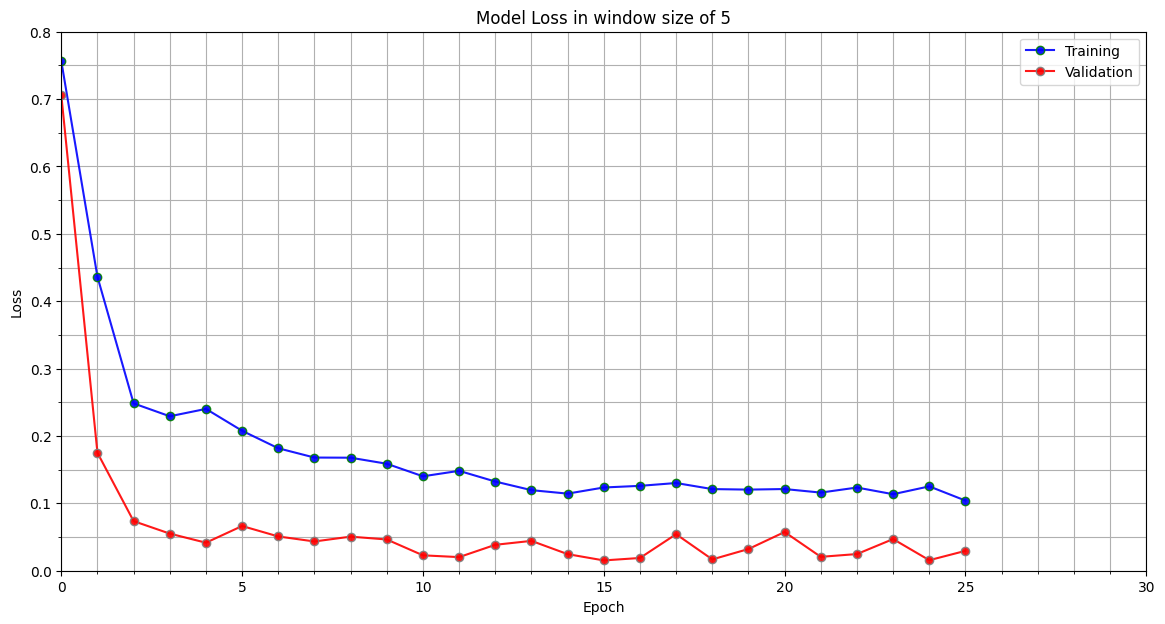

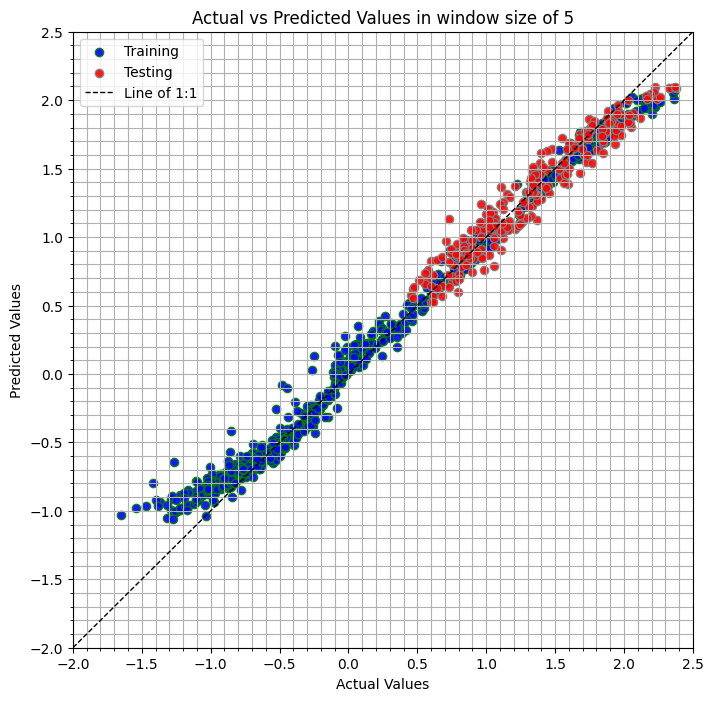

mse: 6185.915, rmse: 78.651, mae: 64.506, mape: 0.016, r2: 0.928 for window size 5
************************************************* End of Window Size: 5 *************************************************



************************************************* Start of Window Size: 10 *************************************************
csv of best hyperparameters record is found
window size of 10 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.1106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 4.35222314878611
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (10, 1)
hyperparameters: {'x0': 4, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 3, 'x5': 18, 'x6': 0.41159767493069166, 'optimizer': 'Adam', 'learning_rate': 0.01}
Train Loss: 0.013894837349653244, Val Loss: 0.0271849874407053
Overfitting Thres

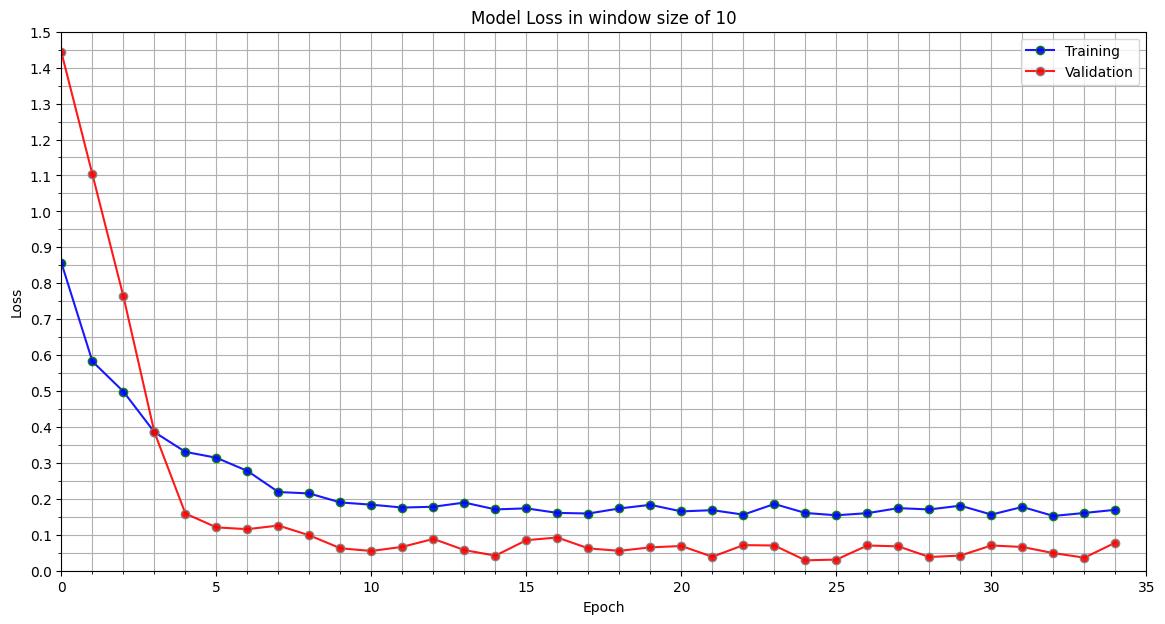

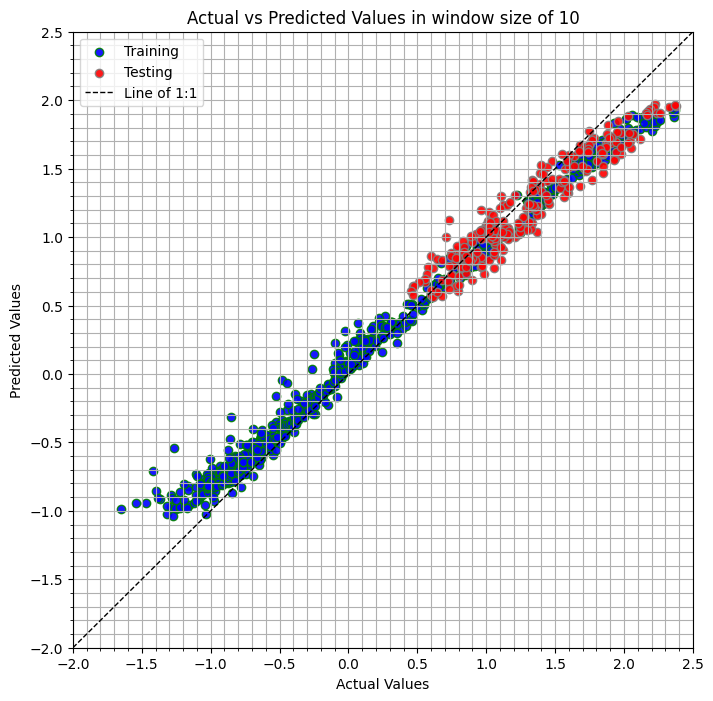

mse: 11720.791, rmse: 108.263, mae: 87.947, mape: 0.021, r2: 0.864 for window size 10
************************************************* End of Window Size: 10 *************************************************



************************************************* Start of Window Size: 30 *************************************************
csv of best hyperparameters record is found
window size of 30 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0089488411322236
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 15, 'x6': 0.475998390958154, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 5.707350068907915
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (30, 1)
hyperparameters: {'x0': 17, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 18, 'x6': 0.5516565129288825, 'optimizer': 'Adam', 'learning_rate': 0.01}
Train Loss: 0.026074741035699844, Val Loss: 0.04027365520596504
Overfitting

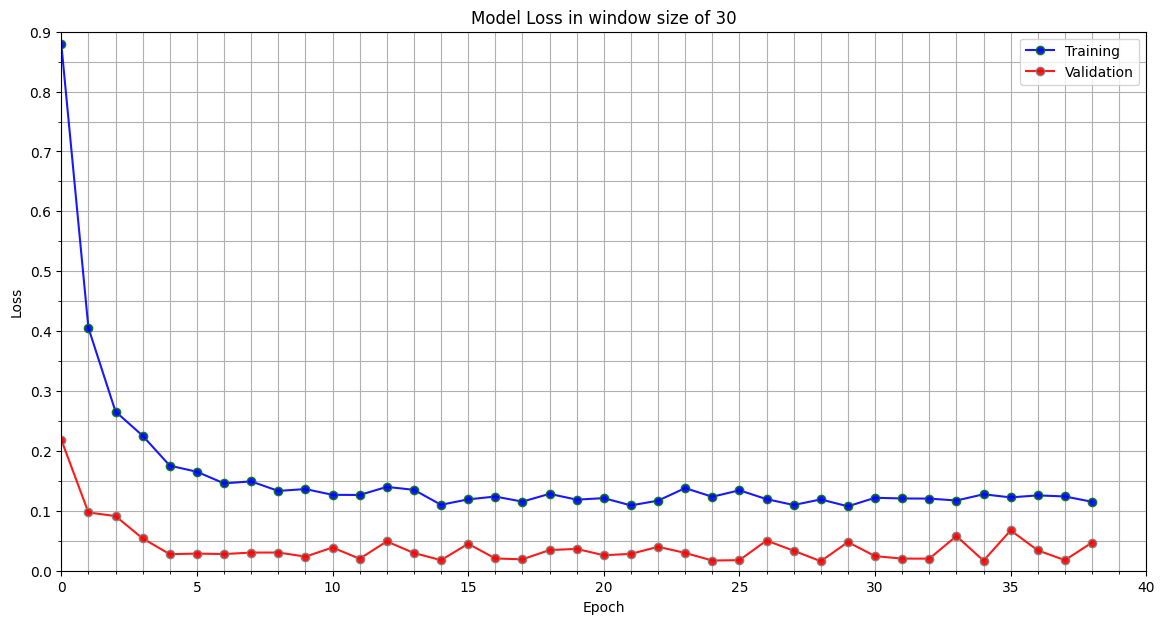

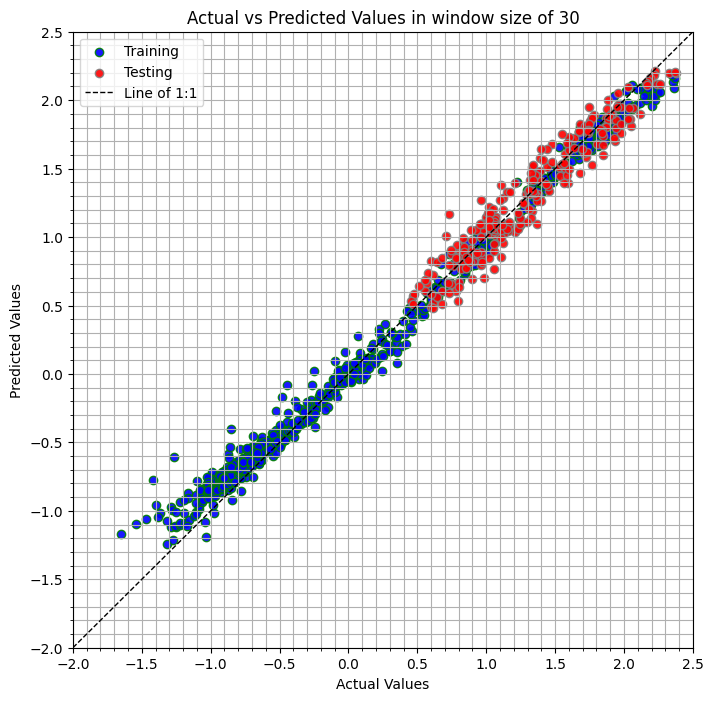

mse: 6404.448, rmse: 80.028, mae: 65.921, mape: 0.016, r2: 0.926 for window size 30
************************************************* End of Window Size: 30 *************************************************



************************************************* Start of Window Size: 60 *************************************************
csv of best hyperparameters record is found
window size of 60 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0135929575189948
Best Hyperparams: {'x0': 20, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 7, 'x6': 0.3071047723028605, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 2.322836341789217
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (60, 1)
hyperparameters: {'x0': 20, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 8, 'x6': 0.3, 'optimizer': 'SGD', 'learning_rate': 0.01}
Train Loss: 0.06088431552052498, Val Loss: 0.06544873118400574
Overfitting Threshold: 0.073061

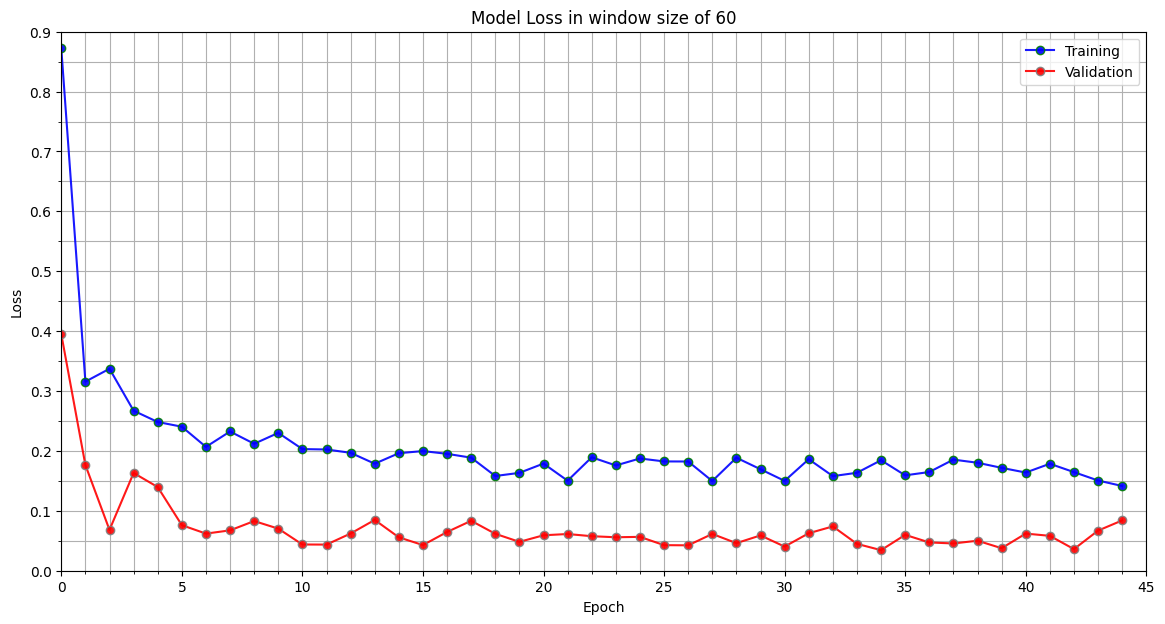

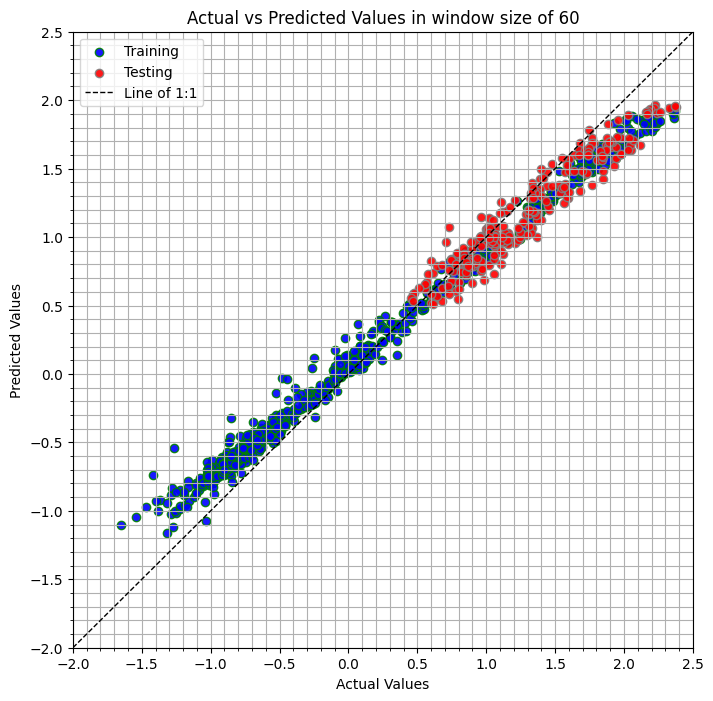

mse: 13892.194, rmse: 117.865, mae: 96.122, mape: 0.023, r2: 0.839 for window size 60
************************************************* End of Window Size: 60 *************************************************



************************************************* Start of Window Size: 120 *************************************************
csv of best hyperparameters record is found
window size of 120 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0098535679280757
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 10, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 11.485013550991523
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (120, 1)
hyperparameters: {'x0': 16, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 13, 'x6': 0.3, 'optimizer': 'Adam', 'learning_rate': 0.001}
Train Loss: 0.021941455081105232, Val Loss: 0.053215015679597855
Overfitting Threshold: 0.026329

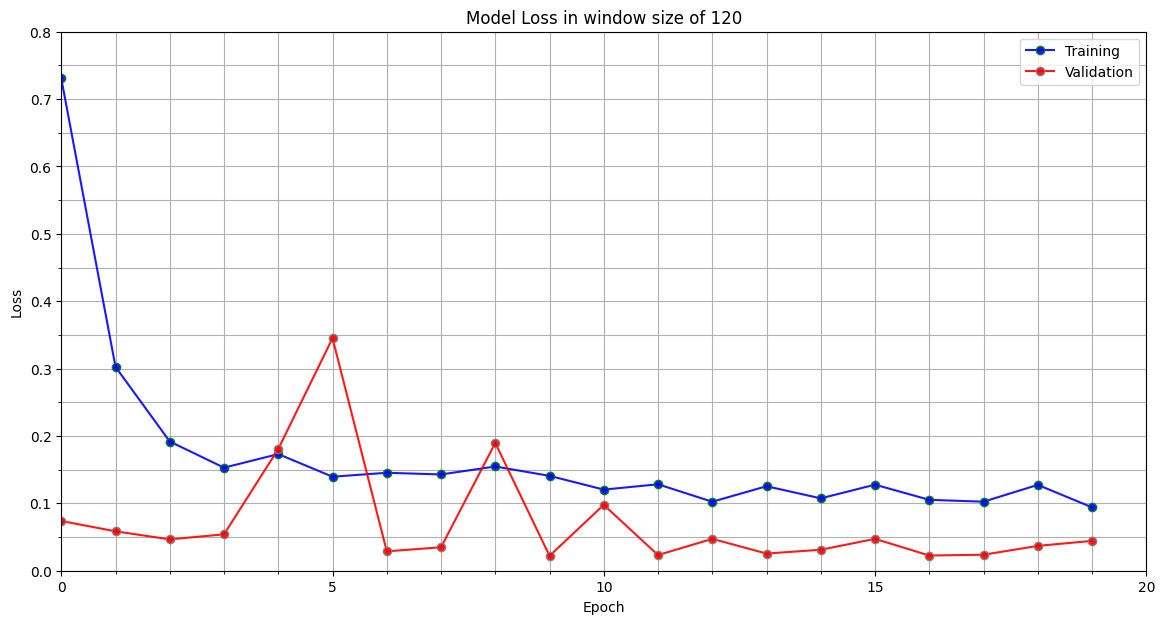

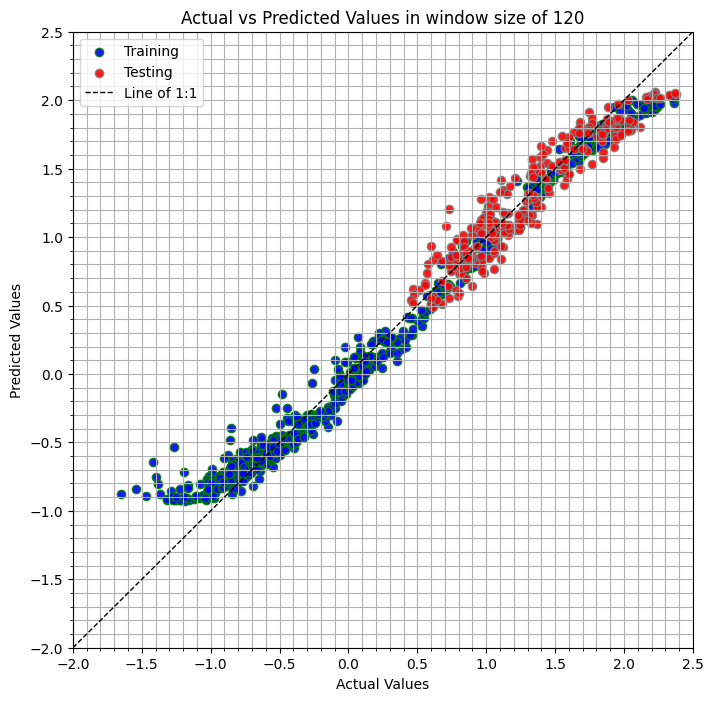

mse: 8941.081, rmse: 94.557, mae: 78.304, mape: 0.019, r2: 0.896 for window size 120
************************************************* End of Window Size: 120 *************************************************



All models trained and evaluated successfully


In [18]:
# Main function to run the program
if __name__ == "__main__":

    ticker="^GSPC"
    start_date="2018-01-01"
    end_date="2023-01-01"
    window_size_list=[5, 10, 30, 60, 120]
    max_iter=1
    population_size=1

    dict_model_main, dict_history_main, dict_result_main, dict_performance_metrix_main, dict_best_params_main, dict_best_loss_main = main_program(
        ticker, start_date, end_date, window_size_list, max_iter, population_size)

# Visualize Result

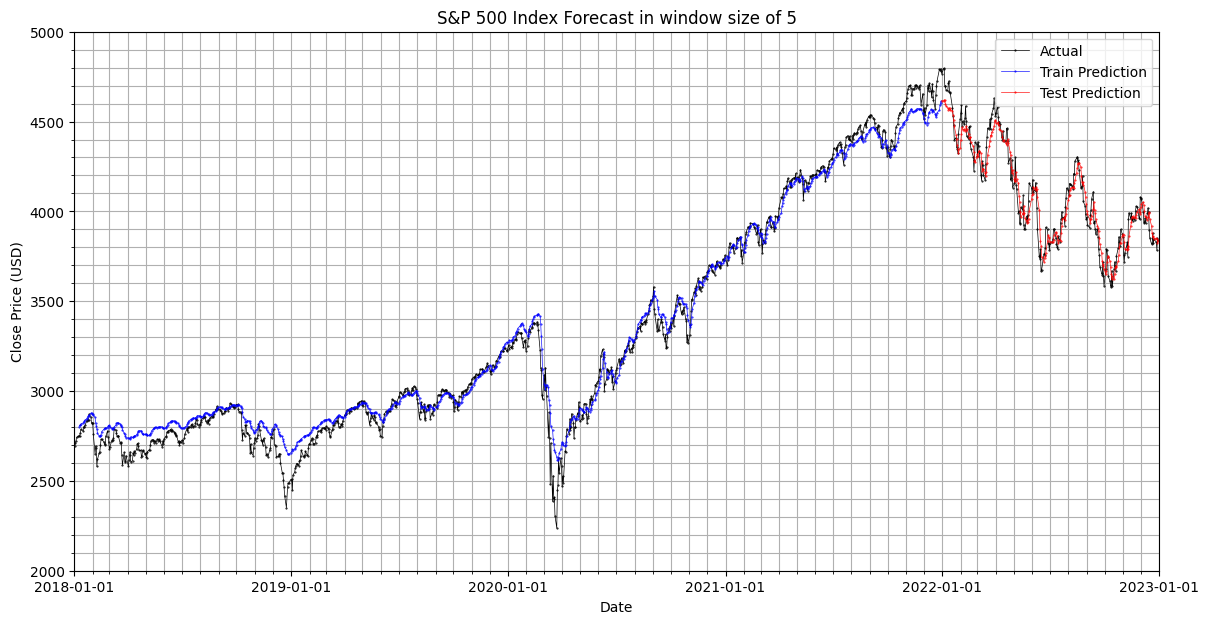

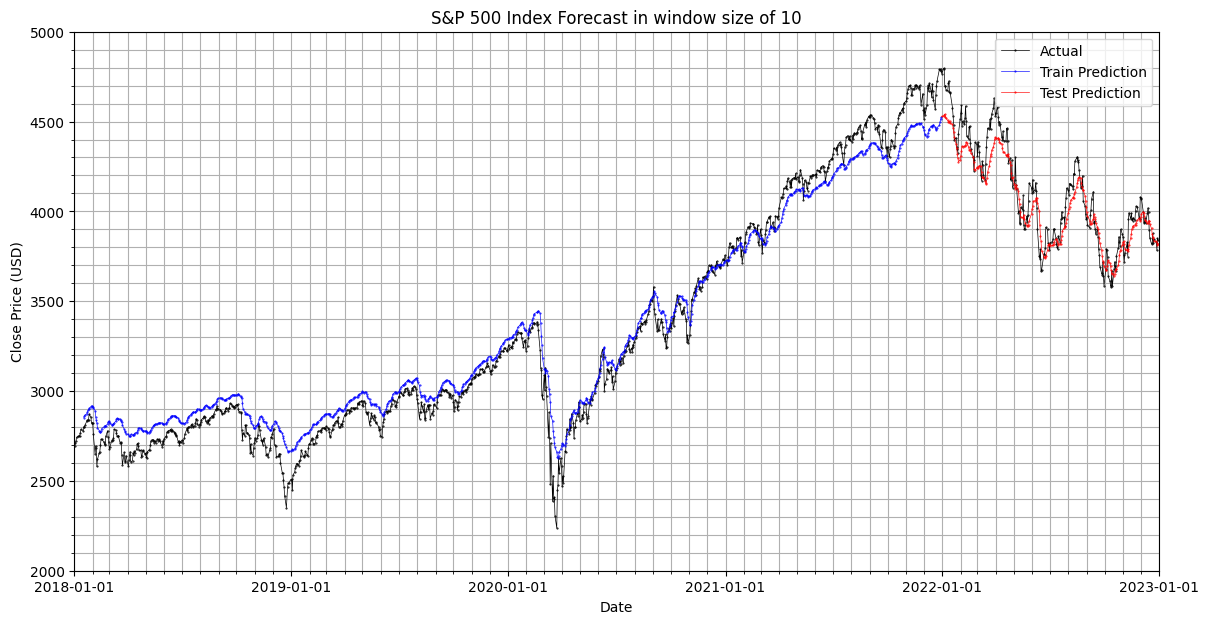

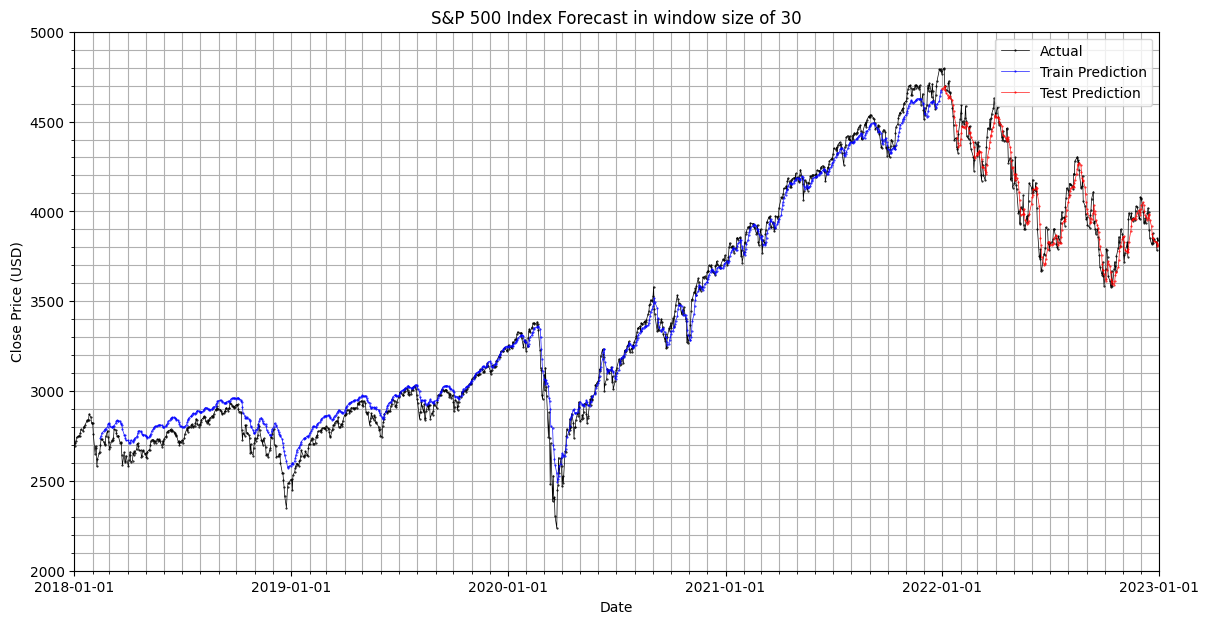

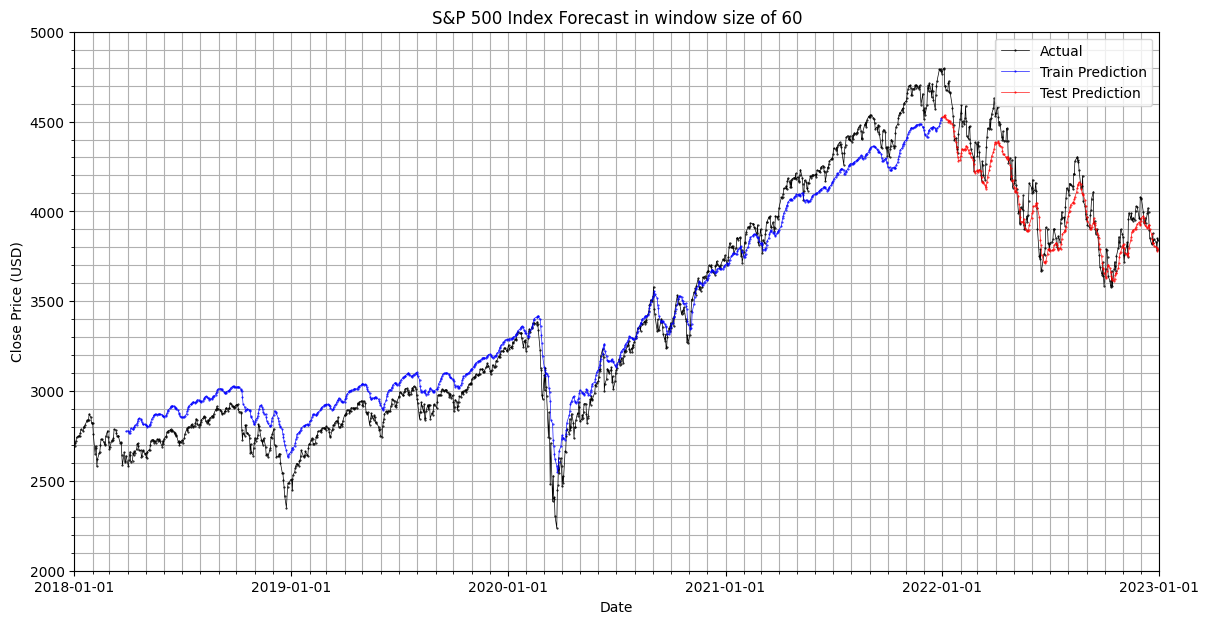

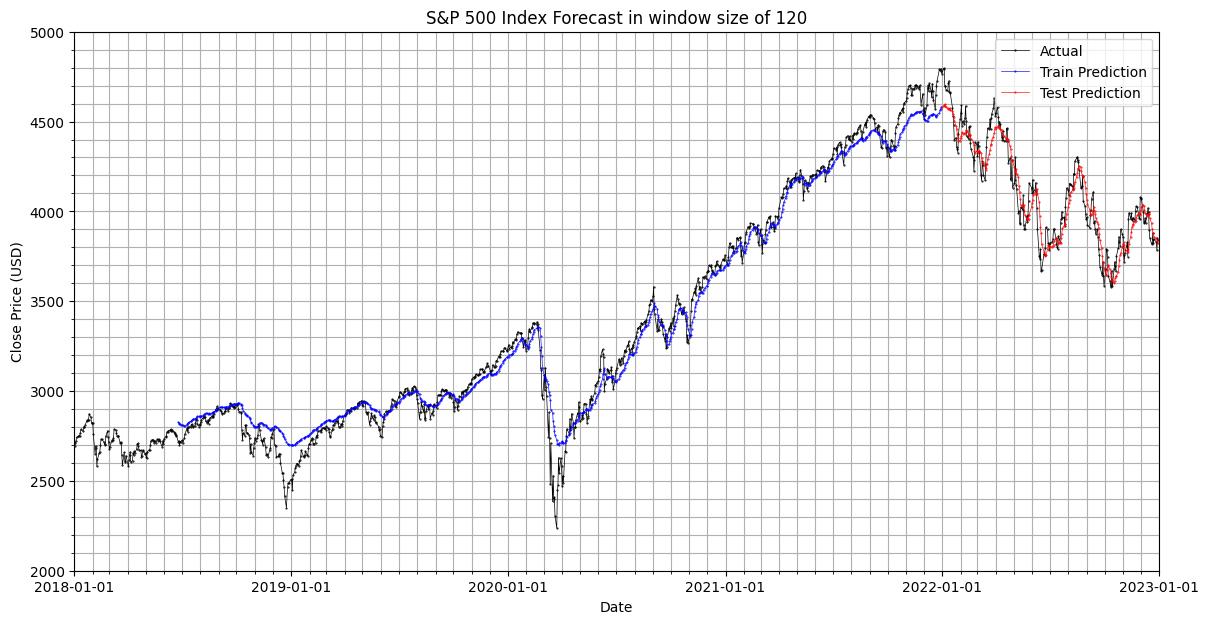

In [19]:
# Plotting the results
plot_results(dict_result_main, start_date, end_date)

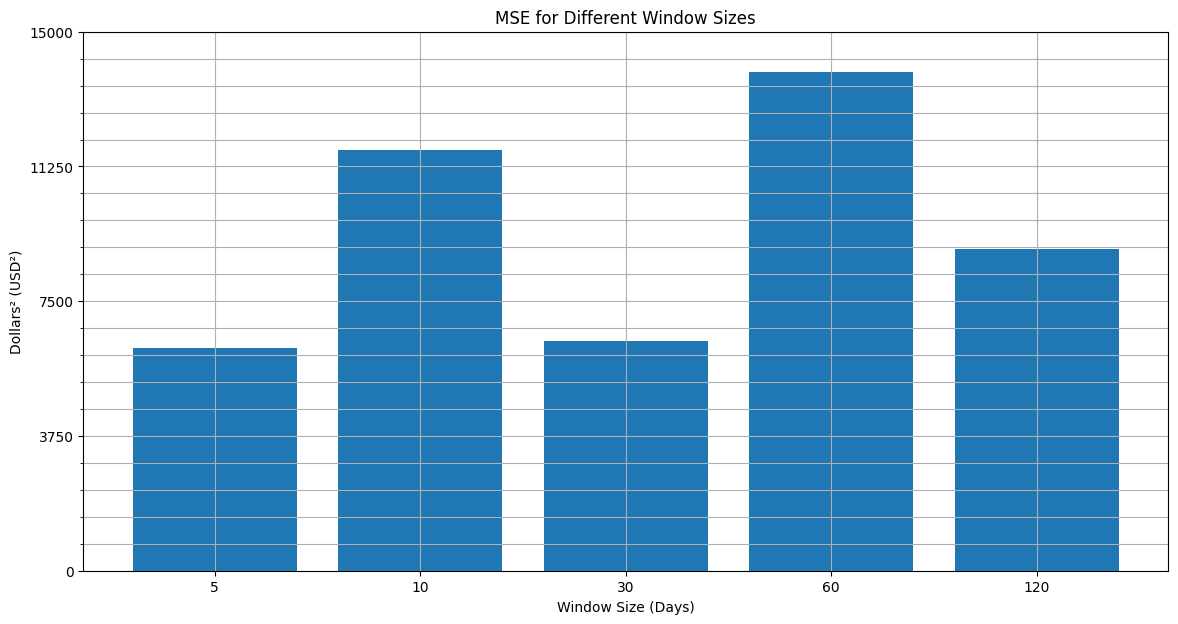

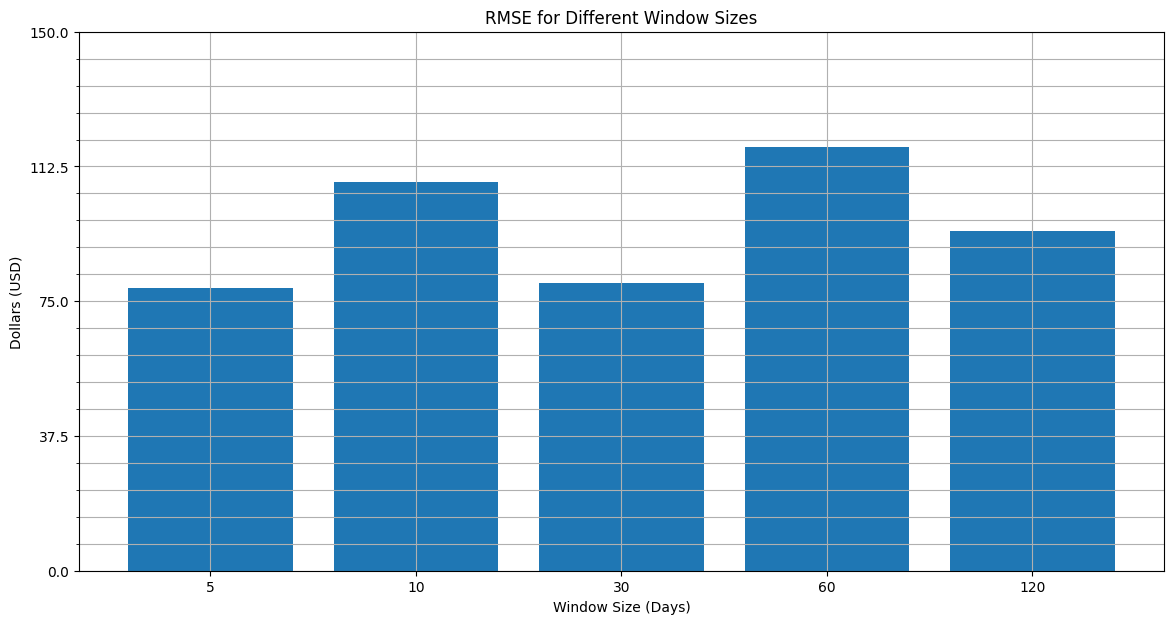

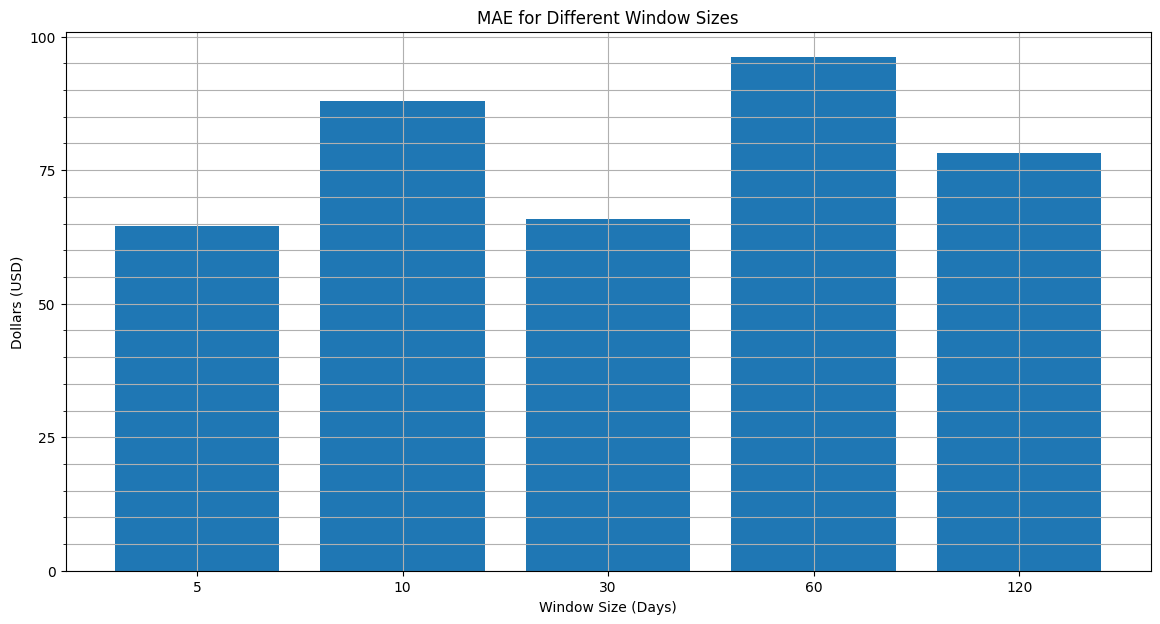

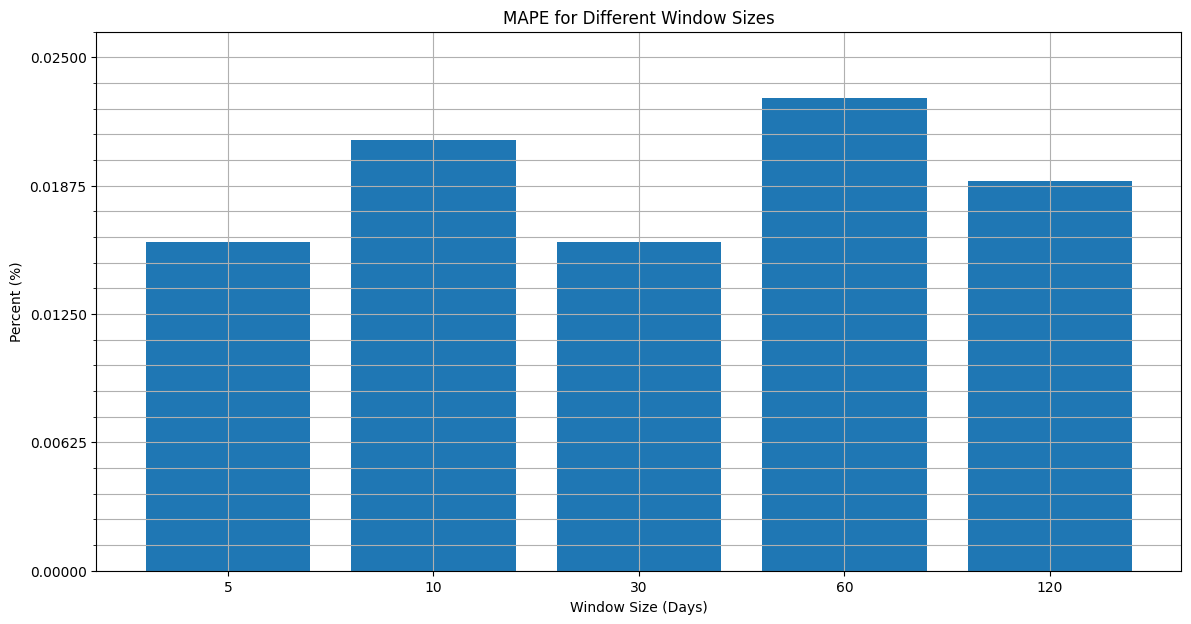

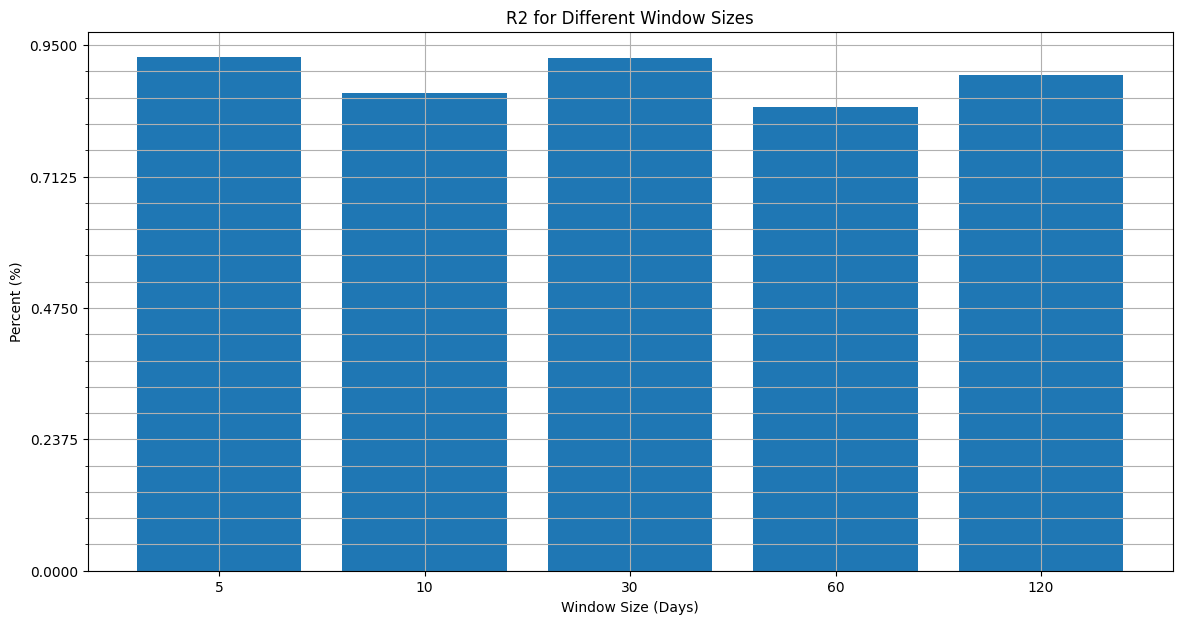

In [20]:
# Plotting the performance metrics
plot_performance_metrix(dict_performance_metrix_main)

# Check if Result saved in CSV successfully

In [21]:
# Display the last 10 records of best hyperparameters
pd.read_csv('best_hyperparameters_record.csv', index_col=0, parse_dates=['time_stamp']).tail(10)

best_loss  x0  x1  x2  x3  x4  x5        x6 optimizer  learning_rate  \
5     0.010645   7   0   0   0   0  16  0.459436      Adam           0.01   
10    0.110645   7   0   0   0   0  16  0.459436      Adam           0.01   
30    0.008949  13   0   0   0   0  15  0.475998      Adam           0.01   
60    0.013593  20   0   0   0   0   7  0.307105      Adam           0.01   
120   0.009854  13   0   0   0   0  10  0.300000   RMSprop           0.01   
5     0.010645   7   0   0   0   0  16  0.459436      Adam           0.01   
10    0.110645   7   0   0   0   0  16  0.459436      Adam           0.01   
30    0.008949  13   0   0   0   0  15  0.475998      Adam           0.01   
60    0.013593  20   0   0   0   0   7  0.307105      Adam           0.01   
120   0.009854  13   0   0   0   0  10  0.300000   RMSprop           0.01   

                    time_stamp  
5   2025-04-14 13:18:21.143250  
10  2025-04-14 13:18:21.143250  
30  2025-04-14 13:18:21.143250  
60  2025-04-14 13:18:21.143250  
120 2025-04-14 13:18:21.143250  
5   2025-04-14 15:48:13.305288  
10  2025-04-14 15:48:13.305288  
30  2025-04-14 15:48:13.305288  
60  2025-04-14 15:48:13.305288  
120 2025-04-14 15:48:13.305288

# Define Cross Validation

In [22]:
def cross_validation(ticker="^GSPC", start_date="2018-01-01", end_date="2023-01-01", 
                window_size_list=[5, 10, 30, 60, 120], max_iter=10, population_size=10, number_of_split=5):
    """
    Cross-validation for different window sizes and folds.
    """
    dict_model = {}
    dict_history = {}
    dict_result = {}
    dict_performance_metrix = {}
    dict_best_params = {}
    dict_best_loss = {}

    # Download stock data
    baseline = "^GSPC"
    data = download_data(ticker, start_date, end_date)
    data_baseline = download_data(baseline, start_date, end_date)
    print()

    # Split main data
    total_data = data['Close'].values
    total_baseline = data_baseline['Close'].values
    split_index_start = [int(len(total_data) / number_of_split * i) for i in range(number_of_split)]
    split_index_end = [int(len(total_data) / number_of_split * i) for i in range(1, number_of_split + 1)]
    print(f"Spliting into {number_of_split} folds, each fold is used for testing")

    # Loop through each window size
    for window_size in window_size_list:

        # time series cross validation
        for i in range(number_of_split):
        # Split main data
            fold_start = split_index_start[i]
            fold_end = split_index_end[i]
            fold_data = total_data[fold_start:fold_end]
            split_index = int(0.8 * len(fold_data))
            train_data = fold_data[:split_index]
            test_data = fold_data[split_index:]

            # Split baseline data
            fold_baseline = total_baseline[fold_start:fold_end]
            train_baseline = fold_baseline[:split_index]
            test_baseline = fold_baseline[split_index:]

            # Normalize main data
            scaler = StandardScaler()
            train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
            test_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()
            combined_scaled = np.concatenate([train_scaled, test_scaled])

            # Normalize baseline data
            scaler_baseline = StandardScaler()
            train_baseline_scaled = scaler_baseline.fit_transform(train_baseline.reshape(-1, 1)).flatten()
            test_baseline_scaled = scaler_baseline.transform(test_baseline.reshape(-1, 1)).flatten()
            combined_baseline_scaled = np.concatenate([train_baseline_scaled, test_baseline_scaled])
        
            # Initialize dictionaries for each window size
            dict_best_params.setdefault(window_size, {})
            dict_best_params[window_size].setdefault(i+1, {})
            dict_best_loss.setdefault(window_size, {})
            dict_best_loss[window_size].setdefault(i+1, {})
            dict_model.setdefault(window_size, {})
            dict_model[window_size].setdefault(i+1, {})
            dict_history.setdefault(window_size, {})
            dict_history[window_size].setdefault(i+1, {})
            dict_result.setdefault(window_size, {})
            dict_result[window_size].setdefault(i+1, {})
            dict_performance_metrix.setdefault(window_size, {})
            dict_performance_metrix[window_size].setdefault(i+1, {})

            # Print the start of the window size and fold
            print("*************************************************", end='')
            print(f" Start of Window Size: {window_size}, Fold: {i+1} ", end='')
            print("*************************************************")

            # Create sequences using combined scaled data
            X_full, y_full = create_windows(combined_scaled, window_size=window_size, horizon=1)
            baseline_full, _ = create_windows(combined_baseline_scaled, window_size=window_size, horizon=1)
            
            # Calculate split point considering window size
            split_point = len(train_scaled) - window_size
            
            # Split into train/test sequences
            X_train, X_test = X_full[:split_point], X_full[split_point:]
            y_train, y_test = y_full[:split_point], y_full[split_point:]
            baseline_train, baseline_test = baseline_full[:split_point], baseline_full[split_point:]

            volatility = calculate_volatility(train_scaled)
            volatility_baseline = calculate_volatility(train_baseline_scaled)

            # ARO Optimization
            best_hyperparams, best_loss = aro_optimization(X_train, y_train, X_test, y_test, 
                                                volatility, volatility_baseline, max_iter=max_iter, 
                                                population_size=population_size, window_size=window_size, 
                                                dict_best_params=dict_best_params)
            dict_best_params[window_size][i+1] = best_hyperparams
            dict_best_loss[window_size][i+1] = best_loss
            

            # Train and evaluate the final model
            print('Training final model with best hyperparameters...')
            result_final_model = train_and_evaluate(X_train, y_train, X_test, y_test, best_hyperparams, window_size, order_of_split=i+1)
            
            # Save results (ensure inverse_transform uses training scaler)
            dict_model, dict_history, dict_result, dict_performance_metrix = save_result_to_dict(
                result_final_model, dict_model, dict_history, dict_result, dict_performance_metrix, 
                data.iloc[fold_start:fold_end], split_index - window_size, scaler, window_size, order_of_split=i+1)  # Adjusted split point
                    
            print("*************************************************", end='')
            print(f" End of Window Size: {window_size}, Fold: {i+1} ", end='')
            print("*************************************************")
            print('\n\n')

    print('All models trained and evaluated successfully')
    return dict_model, dict_history, dict_result, dict_performance_metrix, dict_best_params, dict_best_loss

# Execute Cross Validation

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Spliting into 3 folds, each fold is used for testing
************************************************* Start of Window Size: 5, Fold: 1 *************************************************
csv of best hyperparameters record is found
window size of 5 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 3.5787057262104986
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (5, 1)
hyperparameters: {'x0': 9, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1, 'x5': 11, 'x6': 0.4150389209731529, 'optimizer': 'Adagrad', 'learning_rate': 1e-05}
Train Loss: 0.994803786277771, Val Loss: 2.6964361667633057
Overfitting Threshold: 1.193764543533325
Candidate 1 of Iteration 1/1: overfitting 

Iteration 1/1
Best Loss: 0.0106448186561465
Best Hyperparams: {'x0': 7, 'x1': 

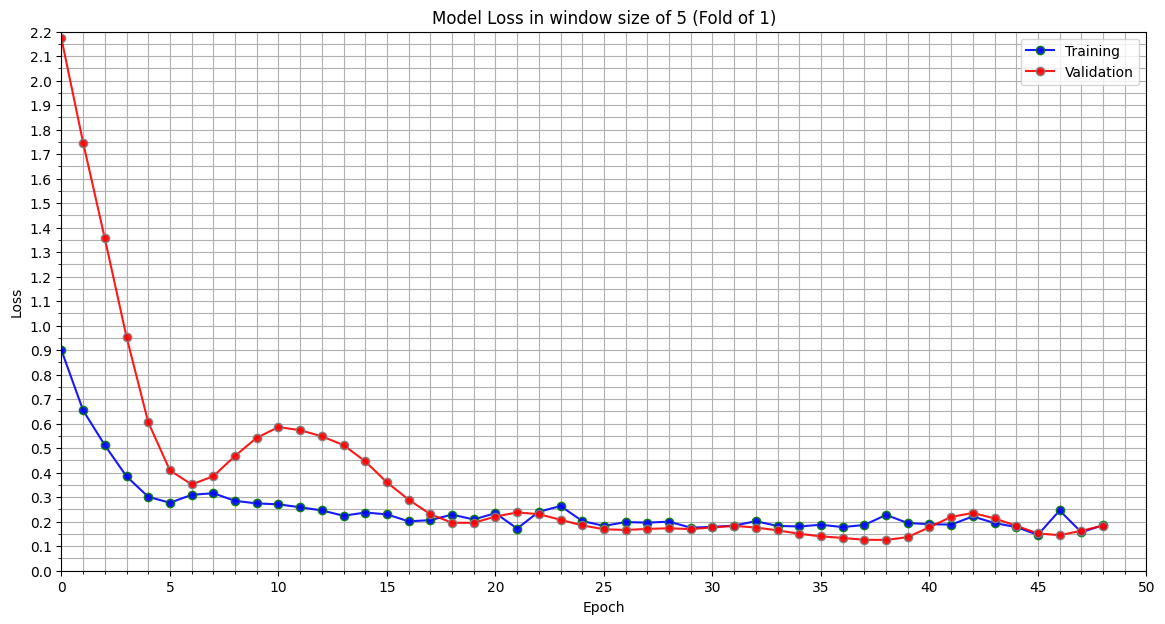

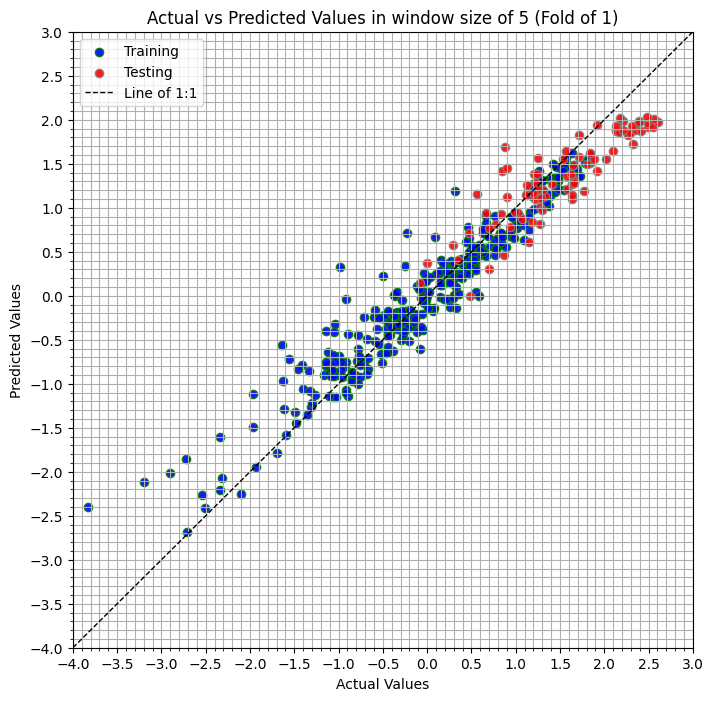

mse: 1383.541, rmse: 37.196, mae: 31.707, mape: 0.011, r2: 0.693 for window size 5
************************************************* End of Window Size: 5, Fold: 1 *************************************************



************************************************* Start of Window Size: 5, Fold: 2 *************************************************
csv of best hyperparameters record is found
window size of 5 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 7.570458585719928
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (5, 1)
hyperparameters: {'x0': 6, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 17, 'x6': 0.5110687518663154, 'optimizer': 'SGD', 'learning_rate': 1e-05}
Train Loss: 1.0045350790023804, Val Loss: 7.264981746673584
Overf

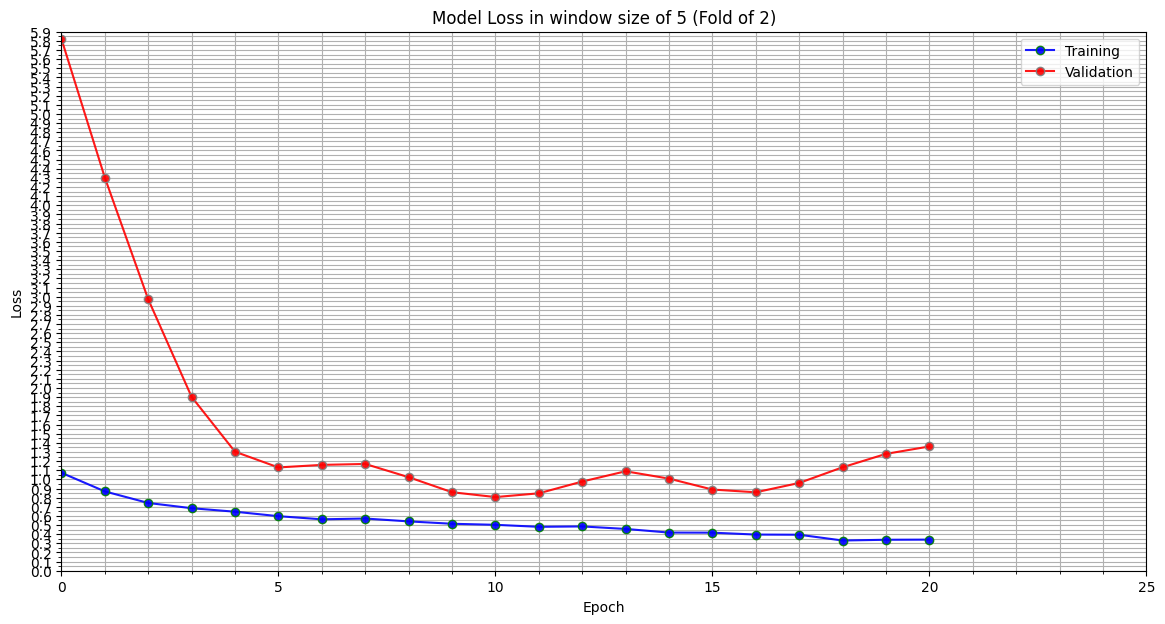

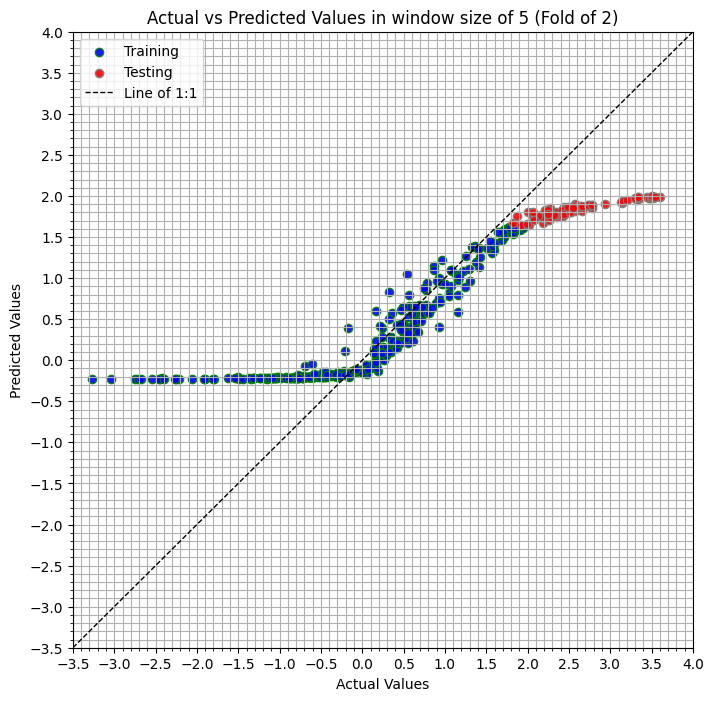

mse: 66374.057, rmse: 257.632, mae: 230.475, mape: 0.058, r2: -2.408 for window size 5
************************************************* End of Window Size: 5, Fold: 2 *************************************************



************************************************* Start of Window Size: 5, Fold: 3 *************************************************
csv of best hyperparameters record is found
window size of 5 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 7.823469280883847
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (5, 1)
hyperparameters: {'x0': 6, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 2, 'x5': 16, 'x6': 0.46580595730843927, 'optimizer': 'RMSprop', 'learning_rate': 0.01}
Train Loss: 0.19406616687774658, Val Loss: 0.274440228939

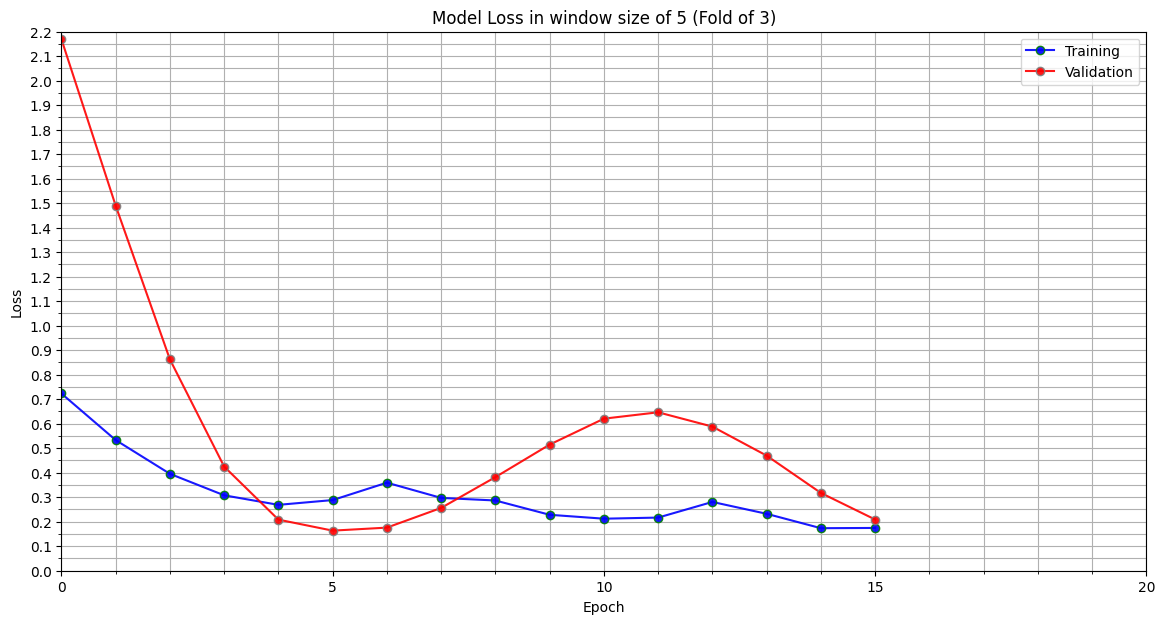

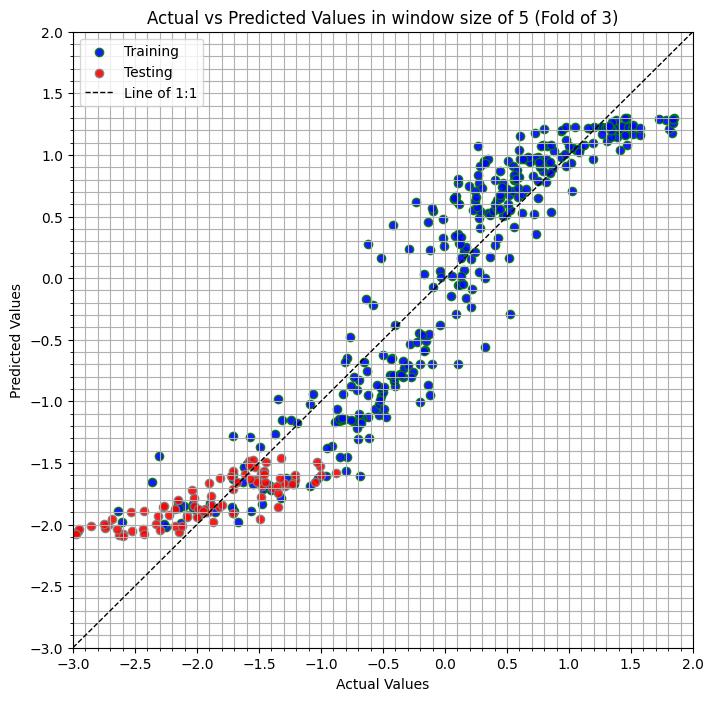

mse: 10360.209, rmse: 101.785, mae: 80.104, mape: 0.021, r2: 0.427 for window size 5
************************************************* End of Window Size: 5, Fold: 3 *************************************************



************************************************* Start of Window Size: 10, Fold: 1 *************************************************
csv of best hyperparameters record is found
window size of 10 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.1106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 1.2174655221208752
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (10, 1)
hyperparameters: {'x0': 9, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 19, 'x6': 0.506041897001596, 'optimizer': 'SGD', 'learning_rate': 0.001}
Train Loss: 1.0215253829956055, Val Loss: 2.64616322517395
O

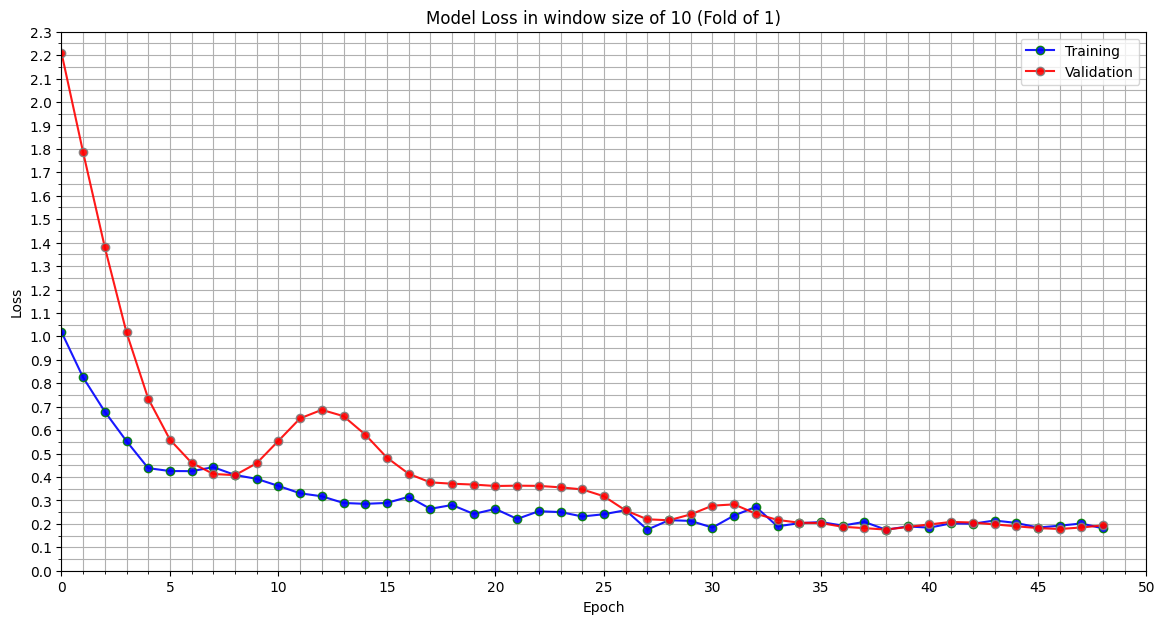

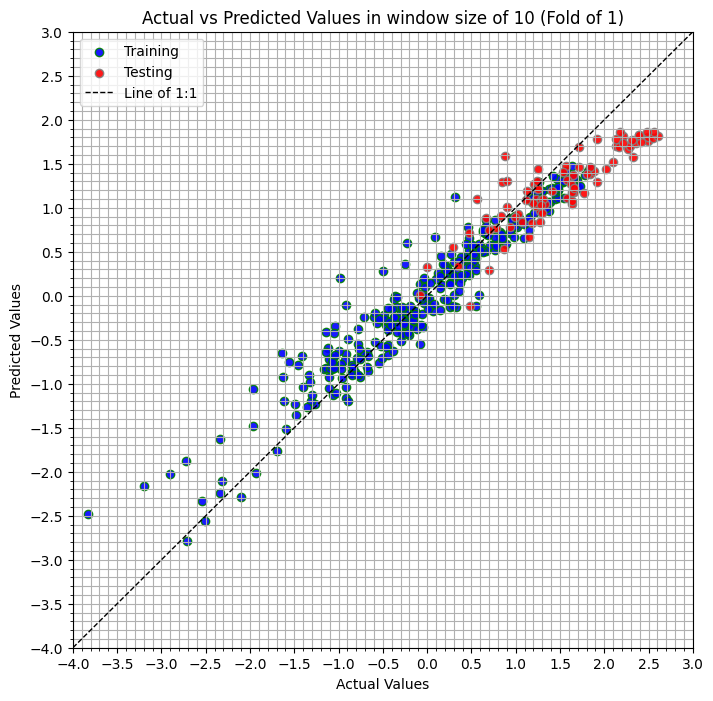

mse: 1933.009, rmse: 43.966, mae: 37.579, mape: 0.013, r2: 0.571 for window size 10
************************************************* End of Window Size: 10, Fold: 1 *************************************************



************************************************* Start of Window Size: 10, Fold: 2 *************************************************
csv of best hyperparameters record is found
window size of 10 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.1106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 0.7204260611702386
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (10, 1)
hyperparameters: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.41353491658012226, 'optimizer': 'Adam', 'learning_rate': 0.01}
Train Loss: 0.06136045977473259, Val Loss: 0.2666958272457

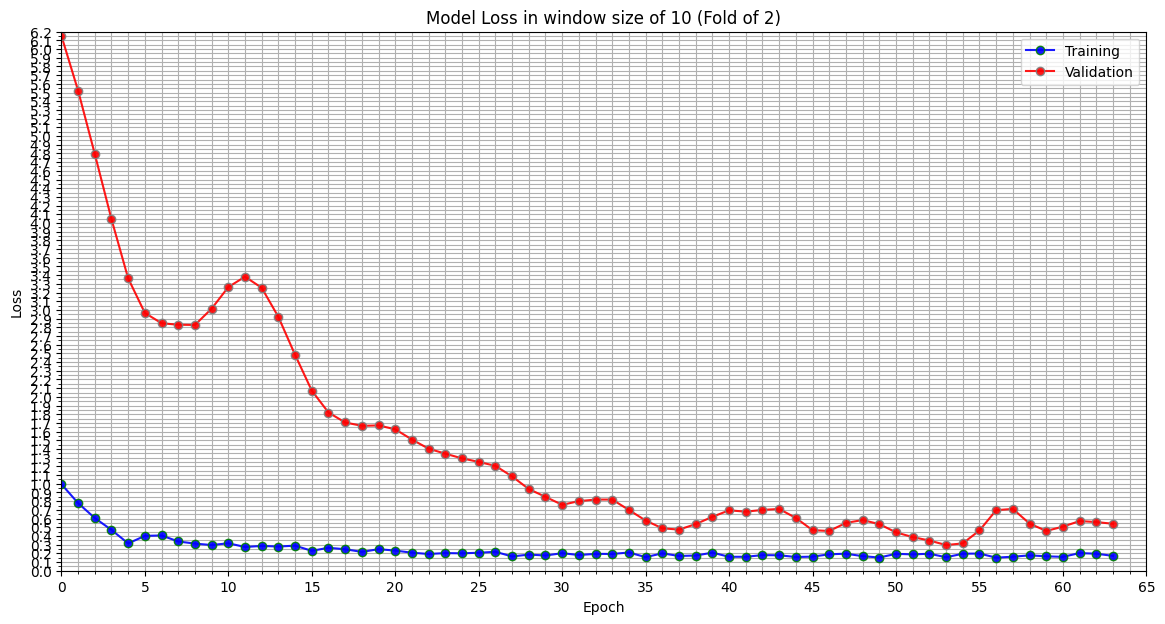

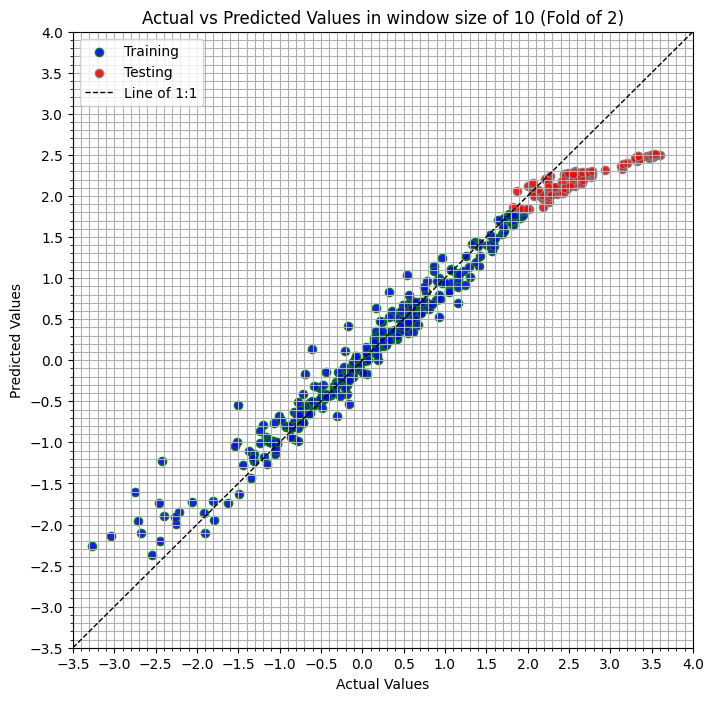

mse: 24310.059, rmse: 155.917, mae: 127.603, mape: 0.032, r2: -0.248 for window size 10
************************************************* End of Window Size: 10, Fold: 2 *************************************************



************************************************* Start of Window Size: 10, Fold: 3 *************************************************
csv of best hyperparameters record is found
window size of 10 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.1106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 6.746431865512549
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (10, 1)
hyperparameters: {'x0': 11, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1, 'x5': 16, 'x6': 0.36017451482808116, 'optimizer': 'Adagrad', 'learning_rate': 0.001}
Train Loss: 0.8582294583320618, Val Loss: 2.990720

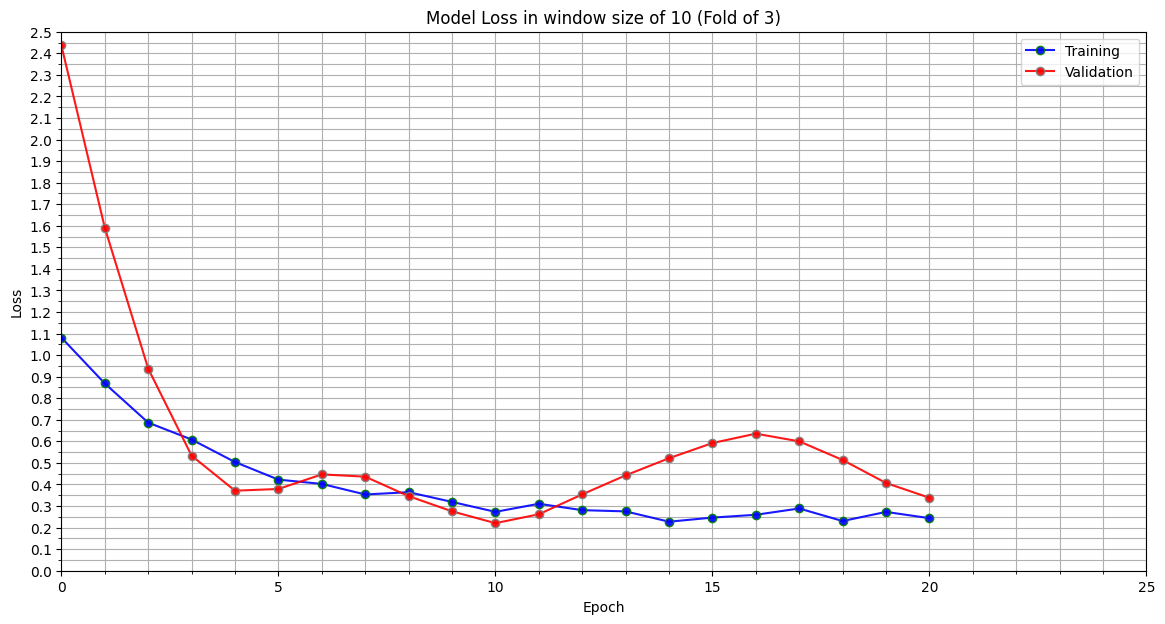

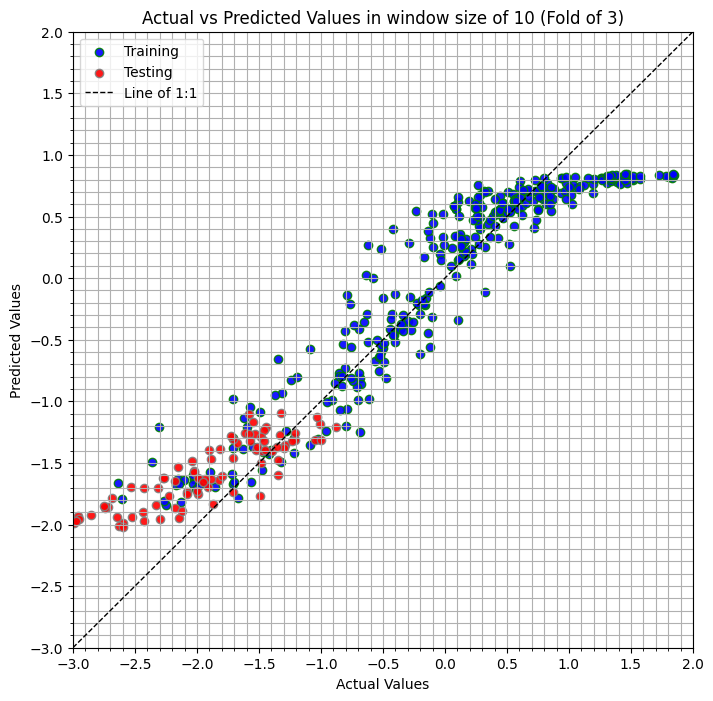

mse: 13967.517, rmse: 118.184, mae: 96.789, mape: 0.026, r2: 0.227 for window size 10
************************************************* End of Window Size: 10, Fold: 3 *************************************************



************************************************* Start of Window Size: 30, Fold: 1 *************************************************
csv of best hyperparameters record is found
window size of 30 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0089488411322236
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 15, 'x6': 0.475998390958154, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 4.484566642953741
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (30, 1)
hyperparameters: {'x0': 8, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 10, 'x6': 0.48619262408658165, 'optimizer': 'RMSprop', 'learning_rate': 1e-05}
Train Loss: 1.0516793727874756, Val Loss: 2.651752948

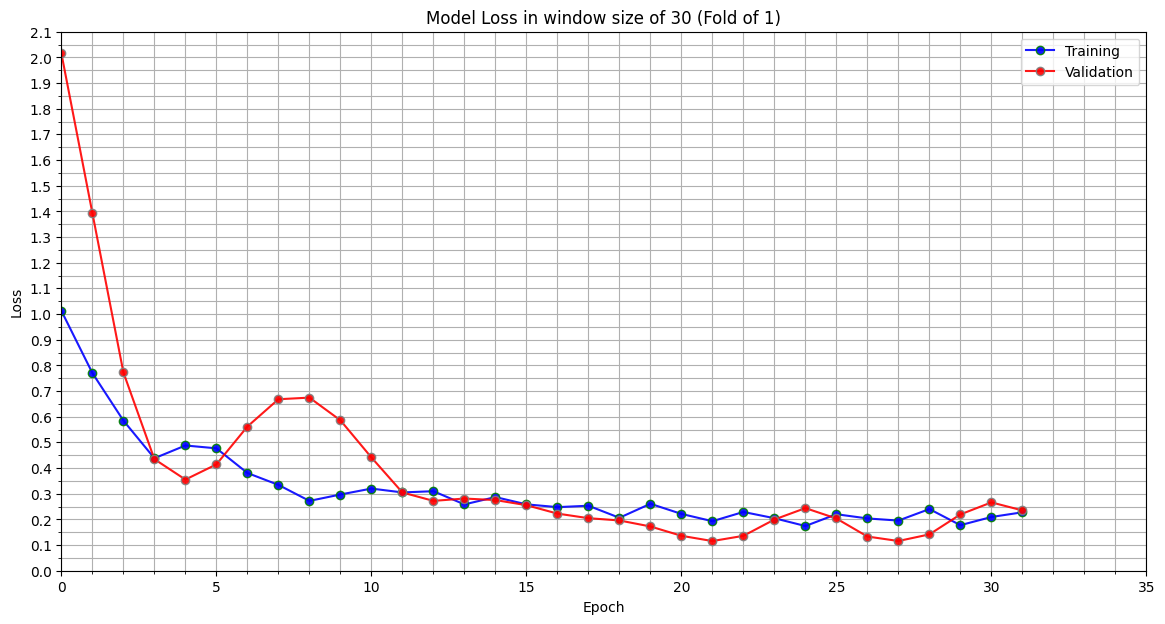

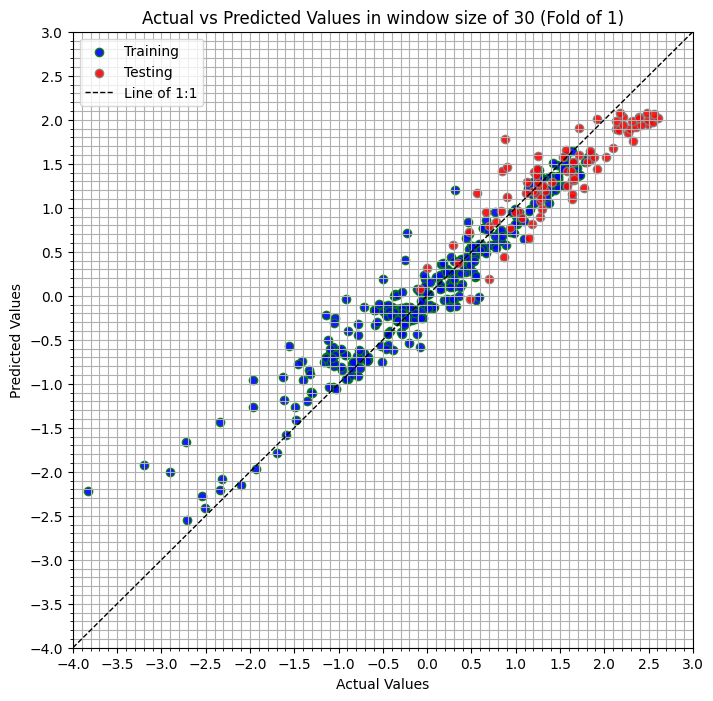

mse: 1272.544, rmse: 35.673, mae: 30.151, mape: 0.01, r2: 0.718 for window size 30
************************************************* End of Window Size: 30, Fold: 1 *************************************************



************************************************* Start of Window Size: 30, Fold: 2 *************************************************
csv of best hyperparameters record is found
window size of 30 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0089488411322236
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 15, 'x6': 0.475998390958154, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 5.83881774617718
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (30, 1)
hyperparameters: {'x0': 10, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 18, 'x6': 0.4944968547904933, 'optimizer': 'SGD', 'learning_rate': 0.001}
Train Loss: 0.7945384383201599, Val Loss: 6.298761367797852
O

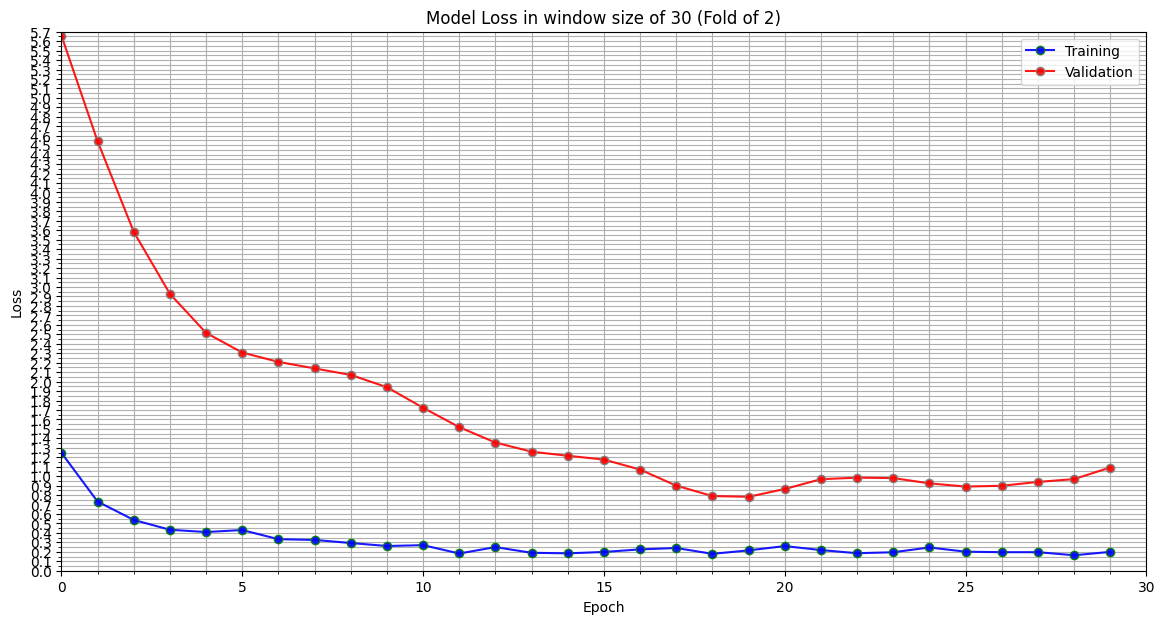

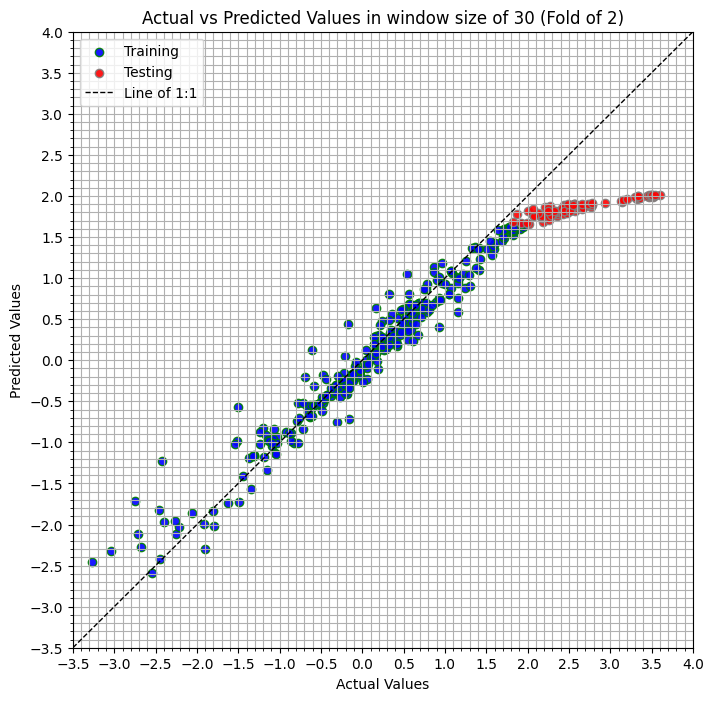

mse: 64379.483, rmse: 253.731, mae: 225.821, mape: 0.056, r2: -2.306 for window size 30
************************************************* End of Window Size: 30, Fold: 2 *************************************************



************************************************* Start of Window Size: 30, Fold: 3 *************************************************
csv of best hyperparameters record is found
window size of 30 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0089488411322236
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 15, 'x6': 0.475998390958154, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 0.1251726231185113
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (30, 1)
hyperparameters: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 15, 'x6': 0.4888494012684431, 'optimizer': 'Adam', 'learning_rate': 0.01}
Train Loss: 0.06449403613805771, Val Loss: 0.091796204

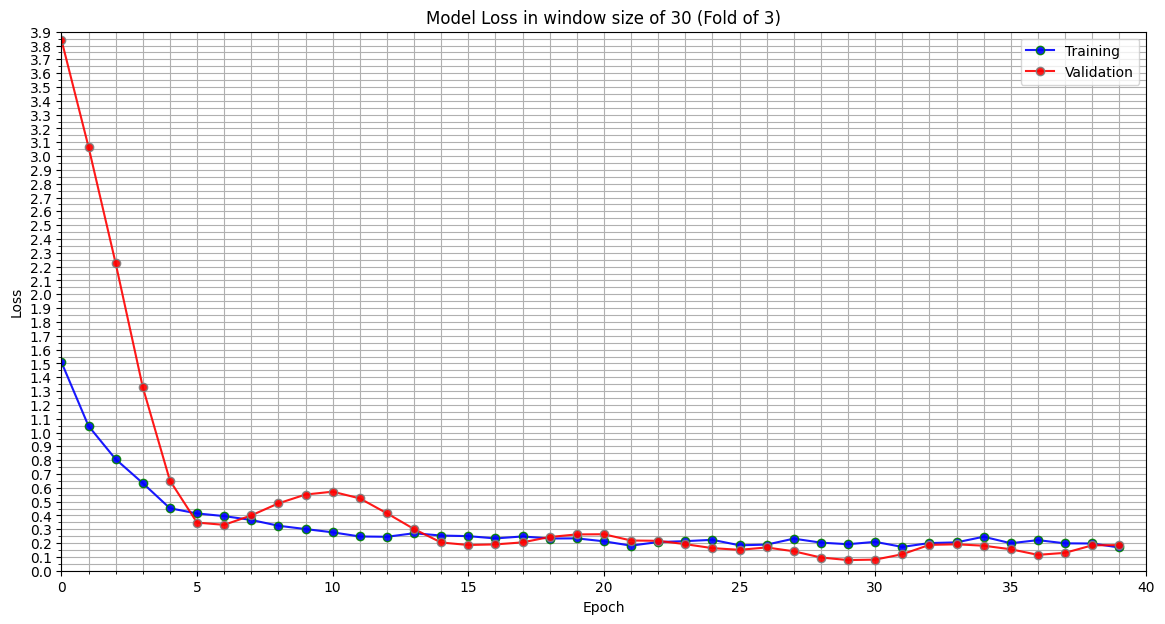

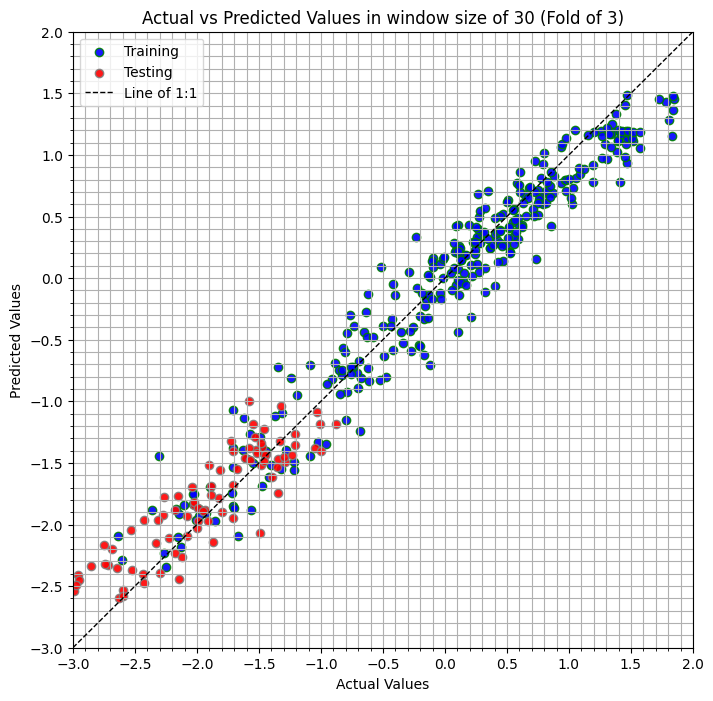

mse: 4880.217, rmse: 69.859, mae: 56.095, mape: 0.015, r2: 0.73 for window size 30
************************************************* End of Window Size: 30, Fold: 3 *************************************************



************************************************* Start of Window Size: 60, Fold: 1 *************************************************
csv of best hyperparameters record is found
window size of 60 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0135929575189948
Best Hyperparams: {'x0': 20, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 7, 'x6': 0.3071047723028605, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 0.9361995462666454
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (60, 1)
hyperparameters: {'x0': 18, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 6, 'x6': 0.34954256522842475, 'optimizer': 'Adam', 'learning_rate': 0.01}
Train Loss: 0.22785848379135132, Val Loss: 0.58677369356155

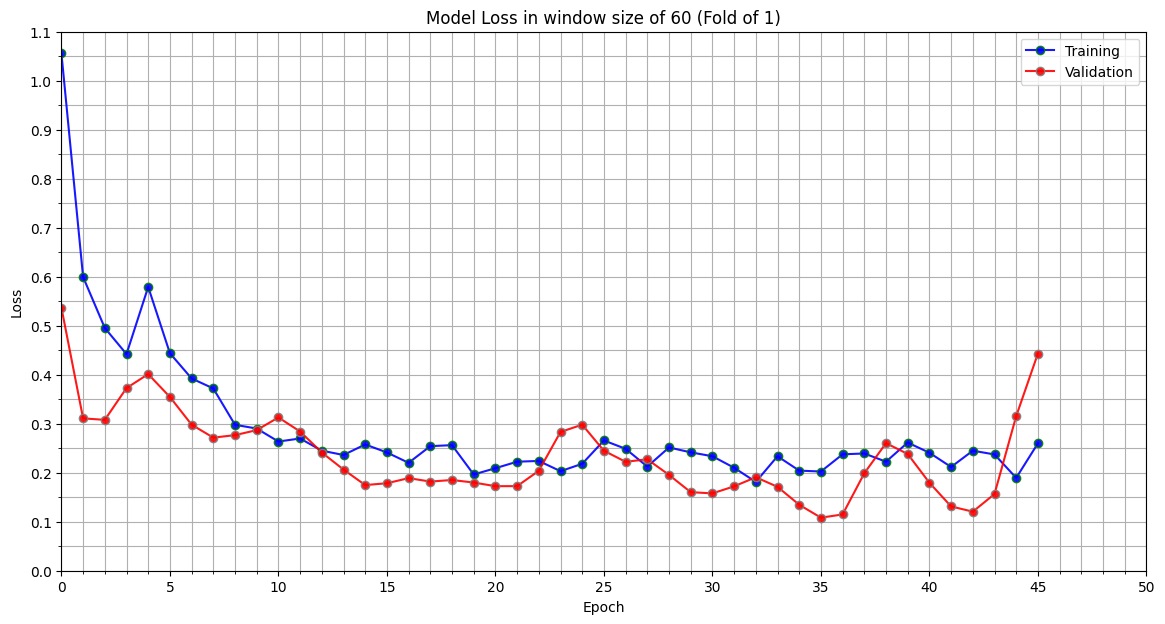

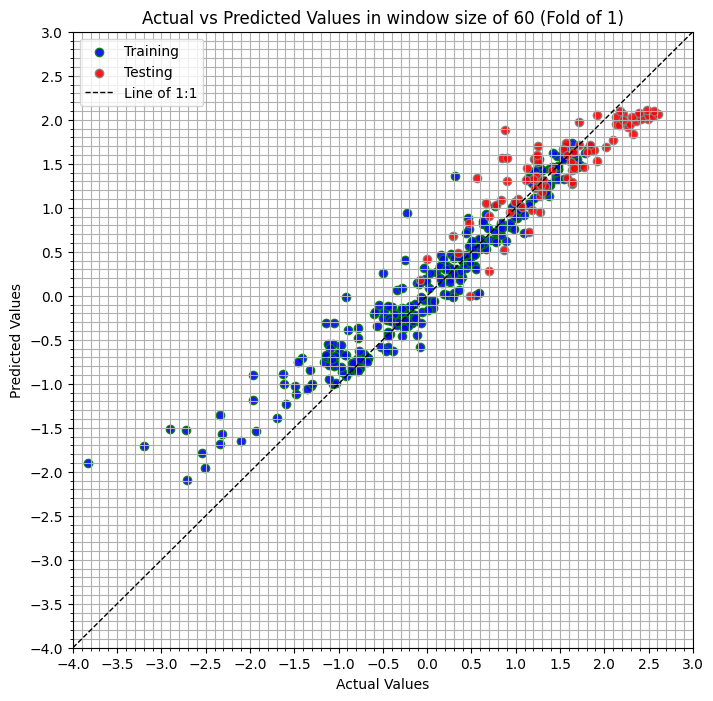

mse: 1191.709, rmse: 34.521, mae: 28.596, mape: 0.01, r2: 0.735 for window size 60
************************************************* End of Window Size: 60, Fold: 1 *************************************************



************************************************* Start of Window Size: 60, Fold: 2 *************************************************
csv of best hyperparameters record is found
window size of 60 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0135929575189948
Best Hyperparams: {'x0': 20, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 7, 'x6': 0.3071047723028605, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 4.170983744614056
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (60, 1)
hyperparameters: {'x0': 20, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 5, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.001}
Train Loss: 0.3878224194049835, Val Loss: 5.237475395202637
Overfitting 

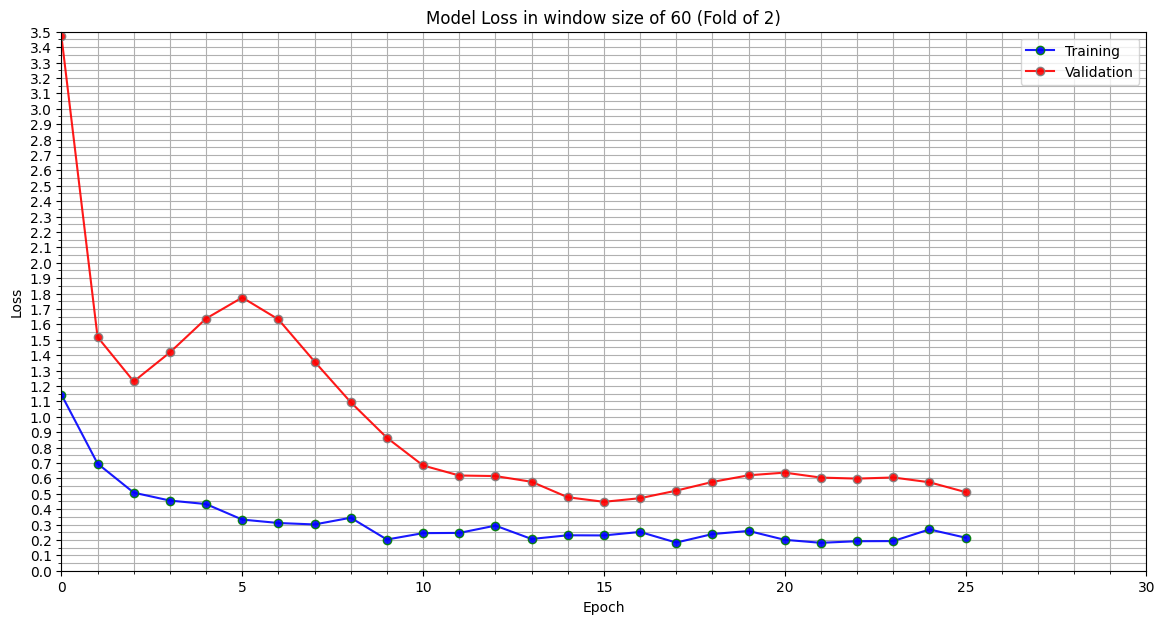

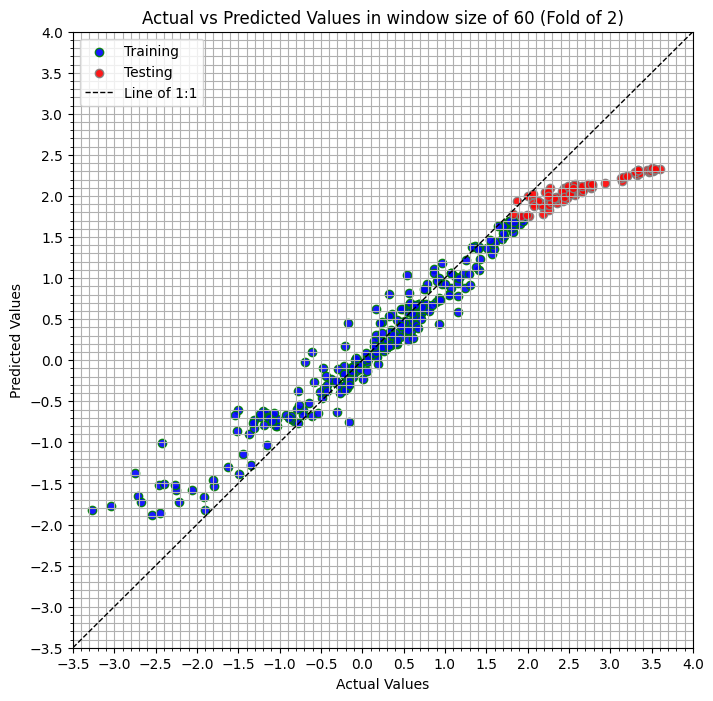

mse: 36845.214, rmse: 191.951, mae: 164.812, mape: 0.041, r2: -0.892 for window size 60
************************************************* End of Window Size: 60, Fold: 2 *************************************************



************************************************* Start of Window Size: 60, Fold: 3 *************************************************
csv of best hyperparameters record is found
window size of 60 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0135929575189948
Best Hyperparams: {'x0': 20, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 7, 'x6': 0.3071047723028605, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 0.048335710436186445
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (60, 1)
hyperparameters: {'x0': 19, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 5, 'x6': 0.3333893916939705, 'optimizer': 'Adam', 'learning_rate': 0.01}
Train Loss: 0.09012927114963531, Val Loss: 0.08327812

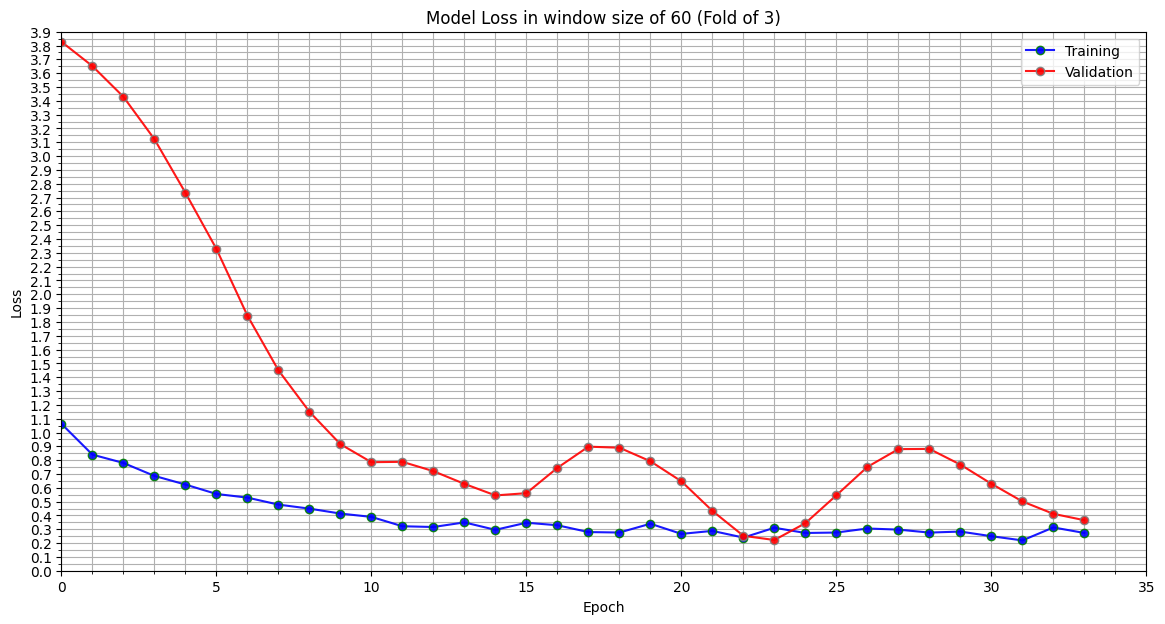

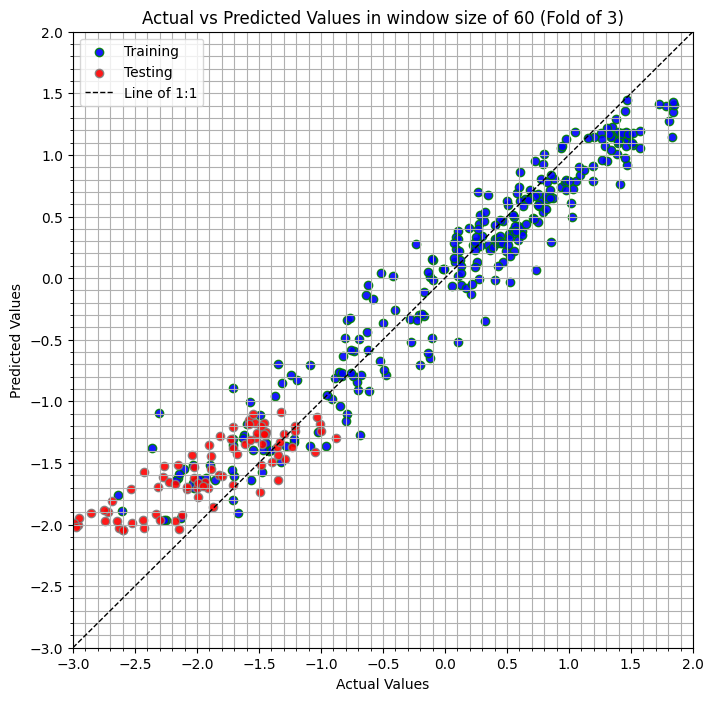

mse: 14071.624, rmse: 118.624, mae: 98.541, mape: 0.026, r2: 0.222 for window size 60
************************************************* End of Window Size: 60, Fold: 3 *************************************************



************************************************* Start of Window Size: 120, Fold: 1 *************************************************
csv of best hyperparameters record is found
window size of 120 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0098535679280757
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 10, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 0.8567540412359428
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (120, 1)
hyperparameters: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 8, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.01}
Train Loss: 0.09782446920871735, Val Loss: 0.1020900085568428
Overfitting Thr

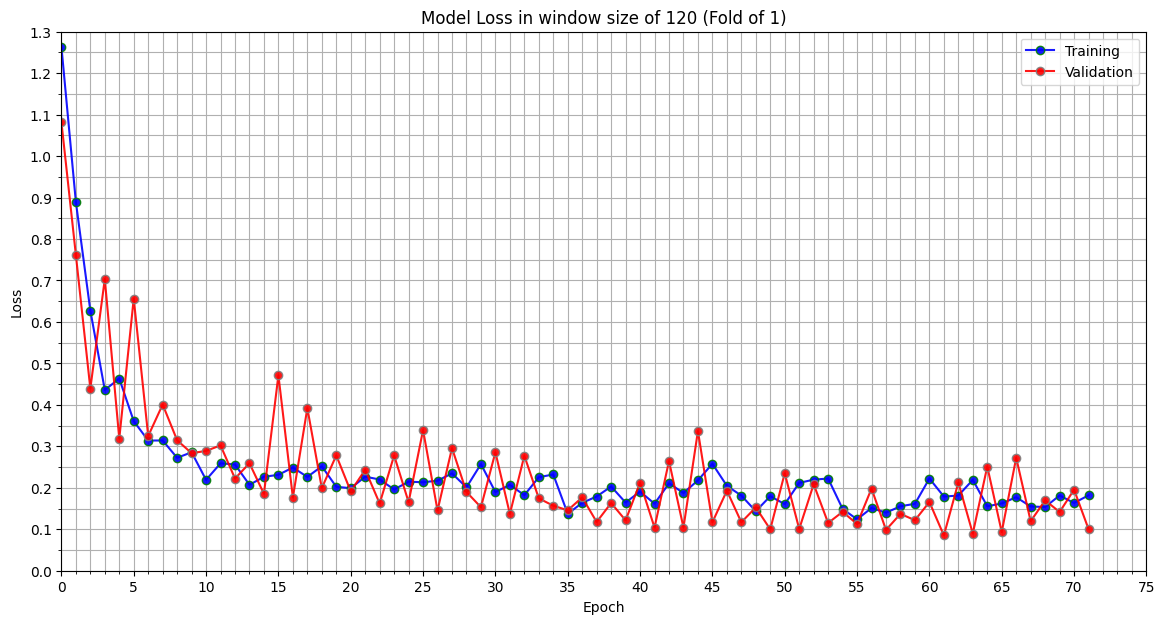

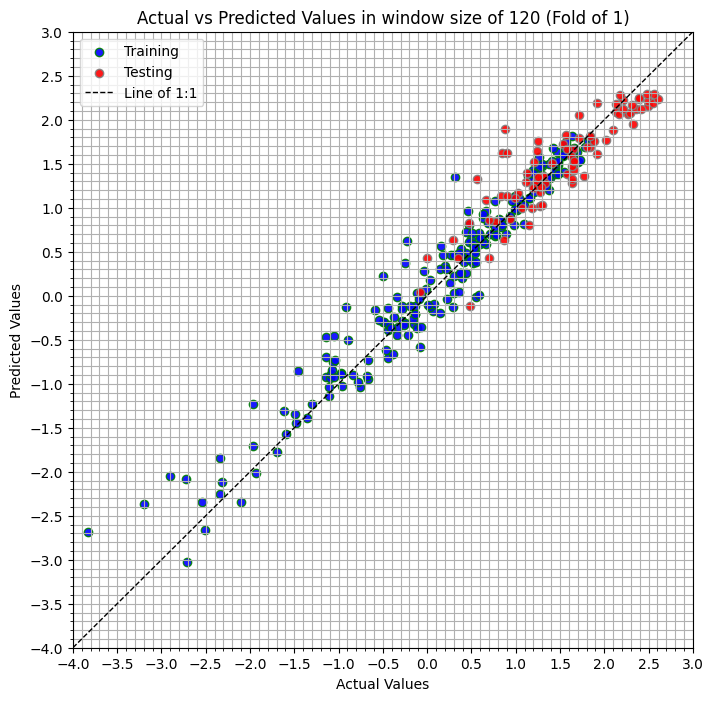

mse: 937.533, rmse: 30.619, mae: 23.763, mape: 0.008, r2: 0.792 for window size 120
************************************************* End of Window Size: 120, Fold: 1 *************************************************



************************************************* Start of Window Size: 120, Fold: 2 *************************************************
csv of best hyperparameters record is found
window size of 120 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0098535679280757
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 10, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 2.812233144324832
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (120, 1)
hyperparameters: {'x0': 8, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 6, 'x6': 0.3, 'optimizer': 'SGD', 'learning_rate': 0.001}
Train Loss: 1.372706413269043, Val Loss: 7.268500804901123
Overfitting Threshold: 1

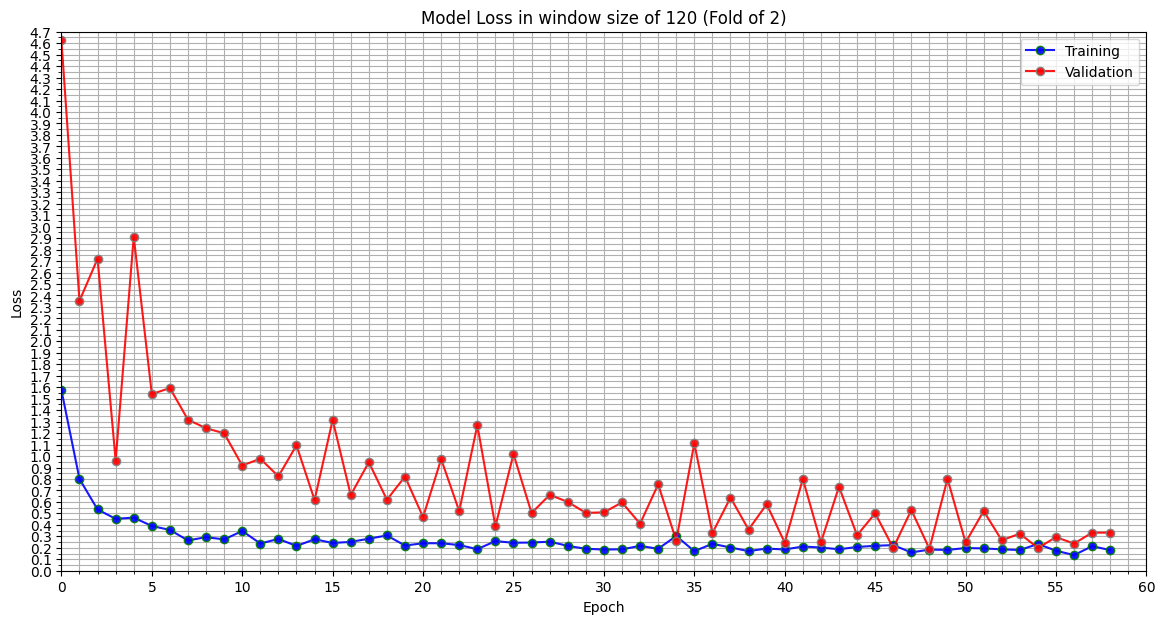

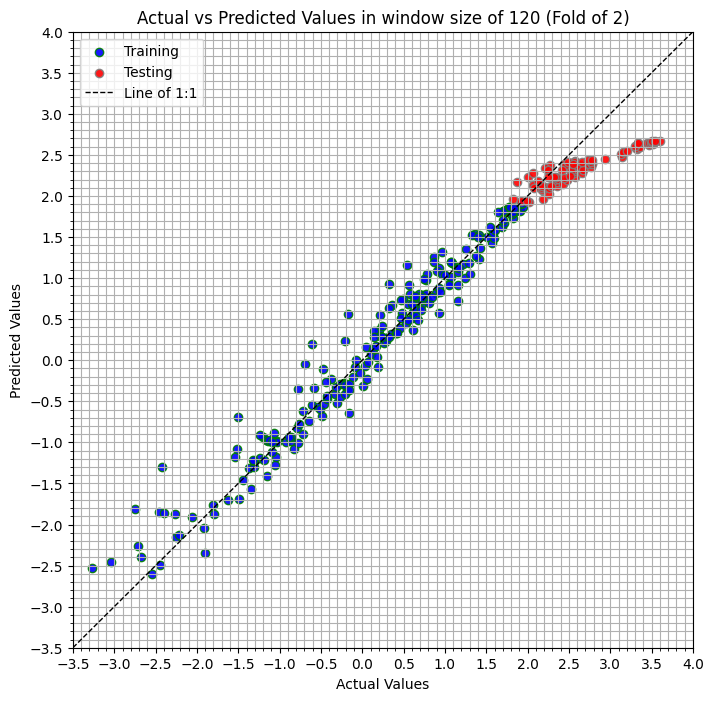

mse: 15728.27, rmse: 125.412, mae: 97.584, mape: 0.024, r2: 0.192 for window size 120
************************************************* End of Window Size: 120, Fold: 2 *************************************************



************************************************* Start of Window Size: 120, Fold: 3 *************************************************
csv of best hyperparameters record is found
window size of 120 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0098535679280757
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 10, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.01} 

Iteration 1/1
Energy: 2.6818692339575514
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (120, 1)
hyperparameters: {'x0': 12, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1, 'x5': 9, 'x6': 0.32766640357912763, 'optimizer': 'Adam', 'learning_rate': 1e-05}
Train Loss: 1.4391813278198242, Val Loss: 3.9891245365142822
O

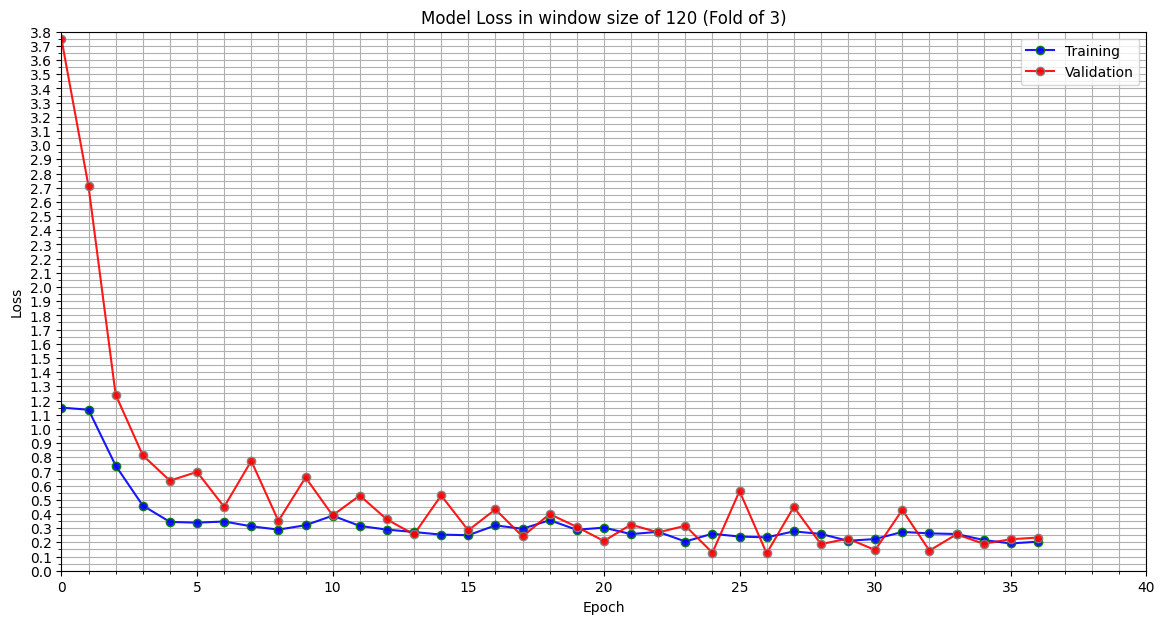

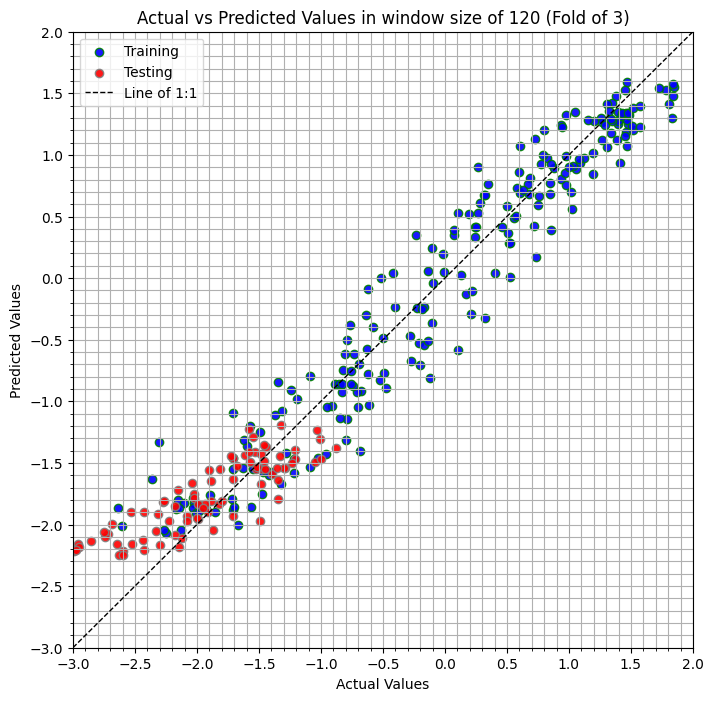

mse: 7743.852, rmse: 87.999, mae: 70.317, mape: 0.019, r2: 0.572 for window size 120
************************************************* End of Window Size: 120, Fold: 3 *************************************************



All models trained and evaluated successfully


In [23]:
# Main function to run the cross validation
if __name__ == "__main__":

    ticker="^GSPC"
    start_date="2018-01-01"
    end_date="2023-01-01"
    window_size_list=[5, 10, 30, 60, 120]
    max_iter=1
    population_size=1
    number_of_split=3

    dict_model_cv, dict_history_cv, dict_result_cv, dict_performance_metrix_cv, dict_best_params_cv, dict_best_loss_cv = cross_validation(
        ticker, start_date, end_date, window_size_list, max_iter, population_size, number_of_split)

# Visualize Result of Cross Validation

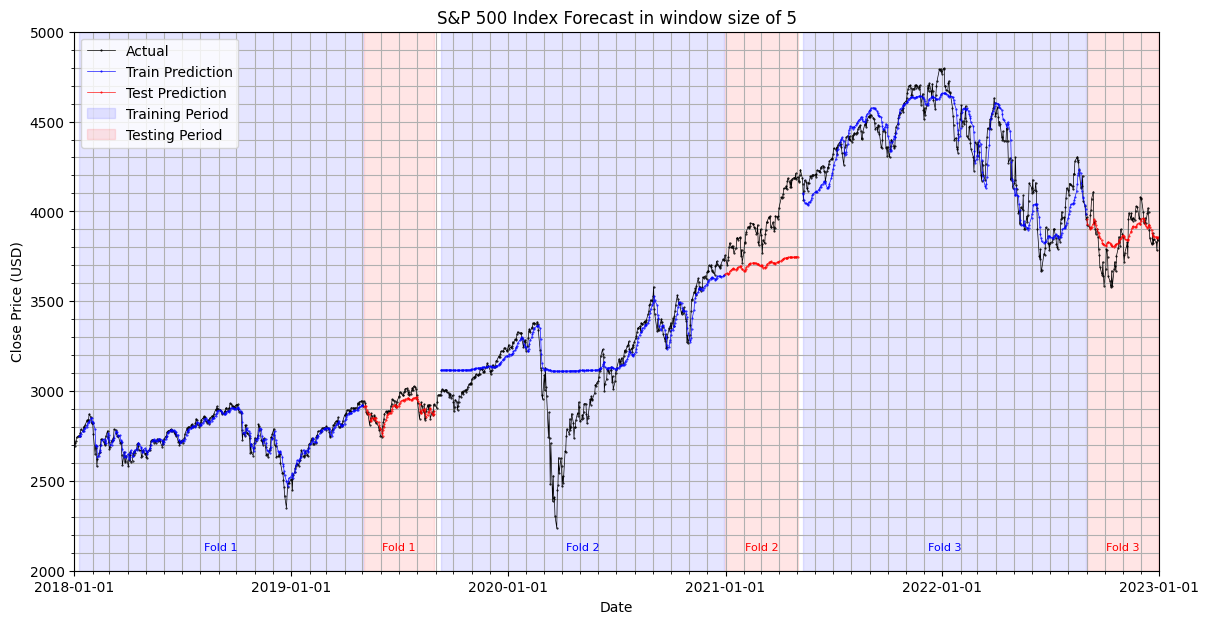

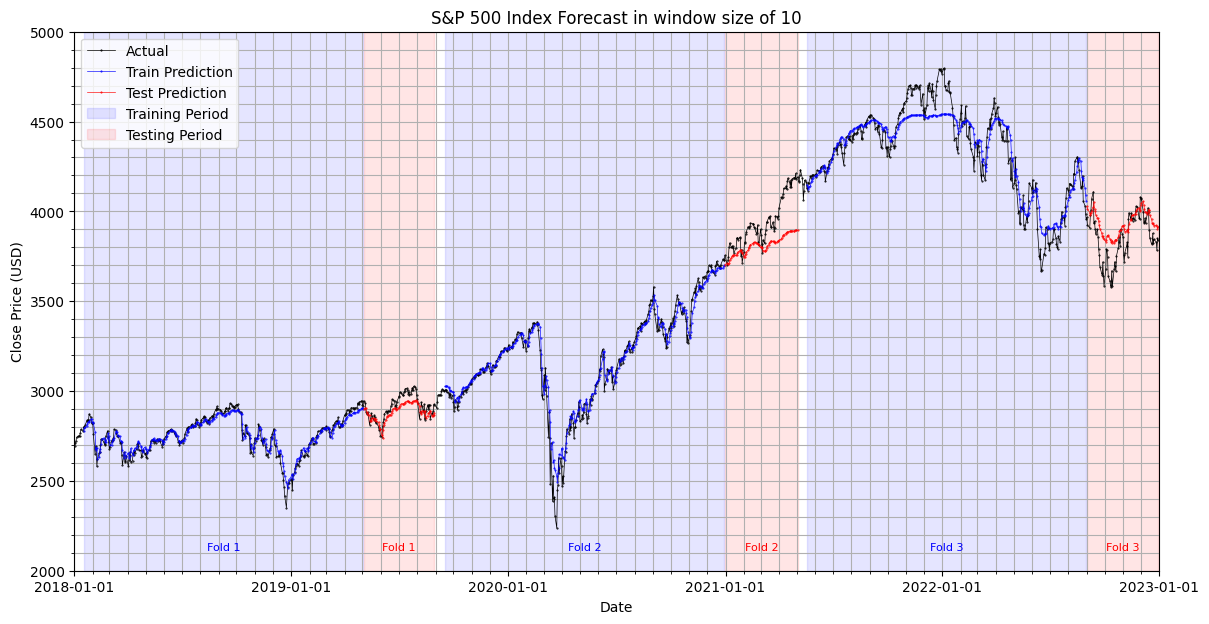

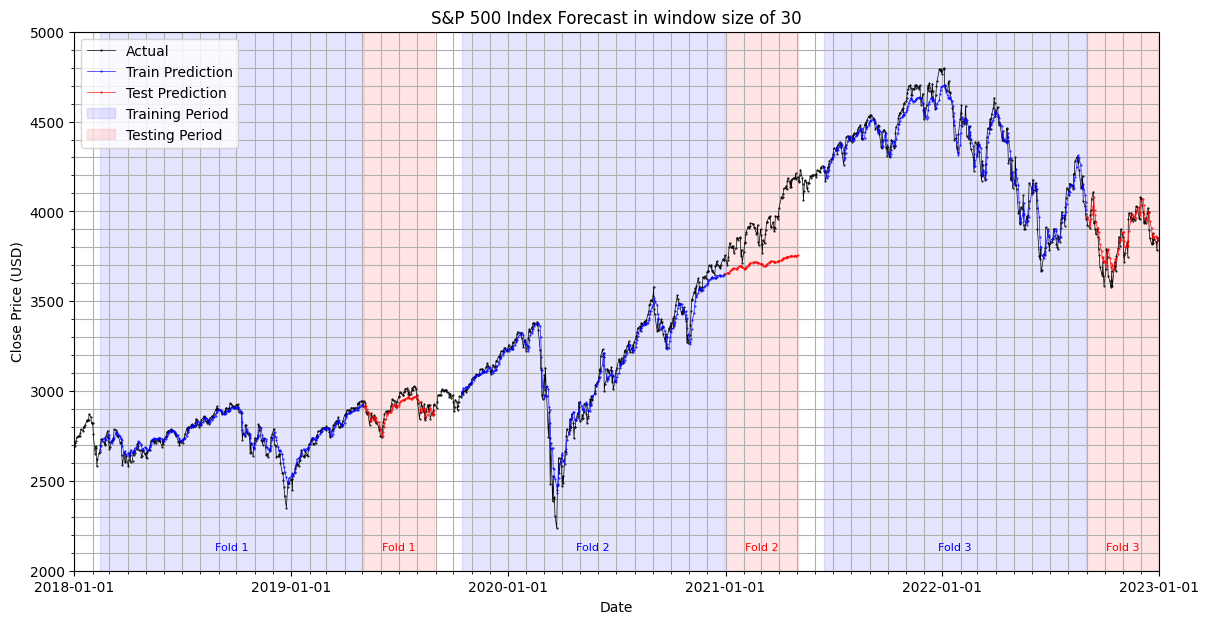

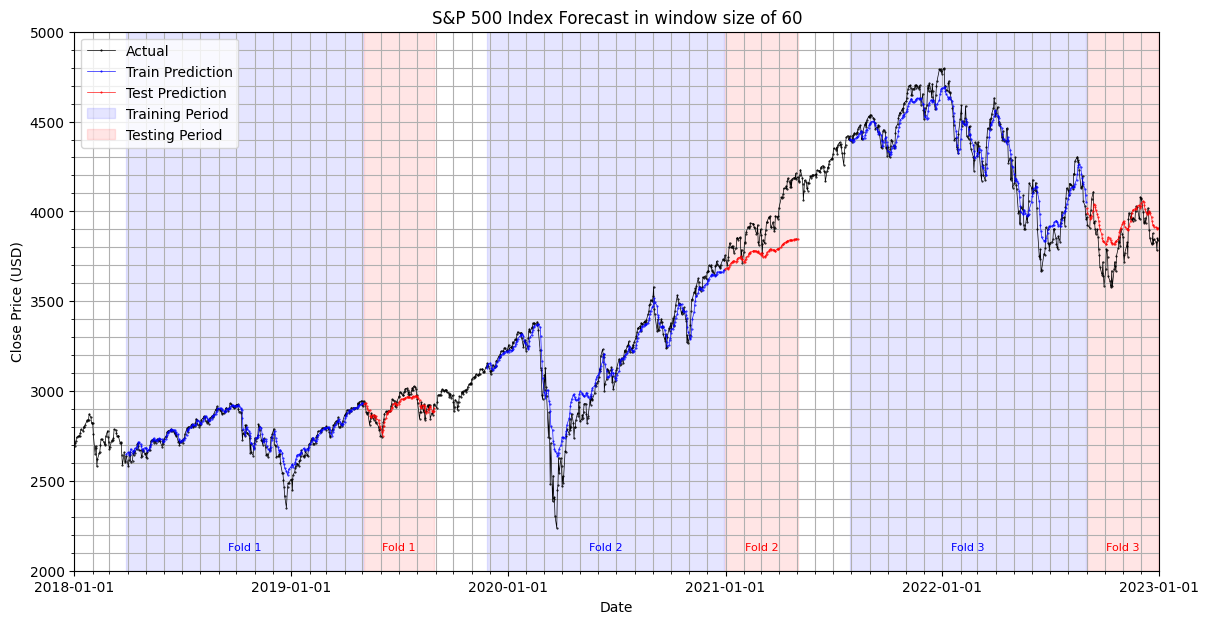

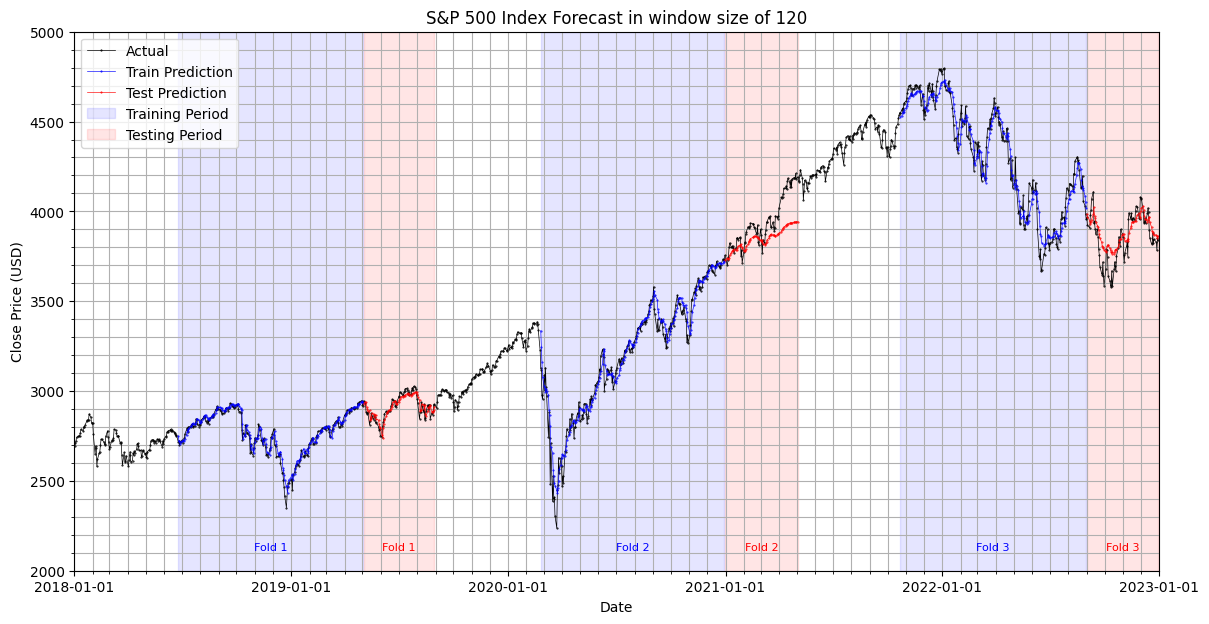

In [24]:
# Plotting the results for cross-validation
plot_results(dict_result_cv, start_date, end_date)

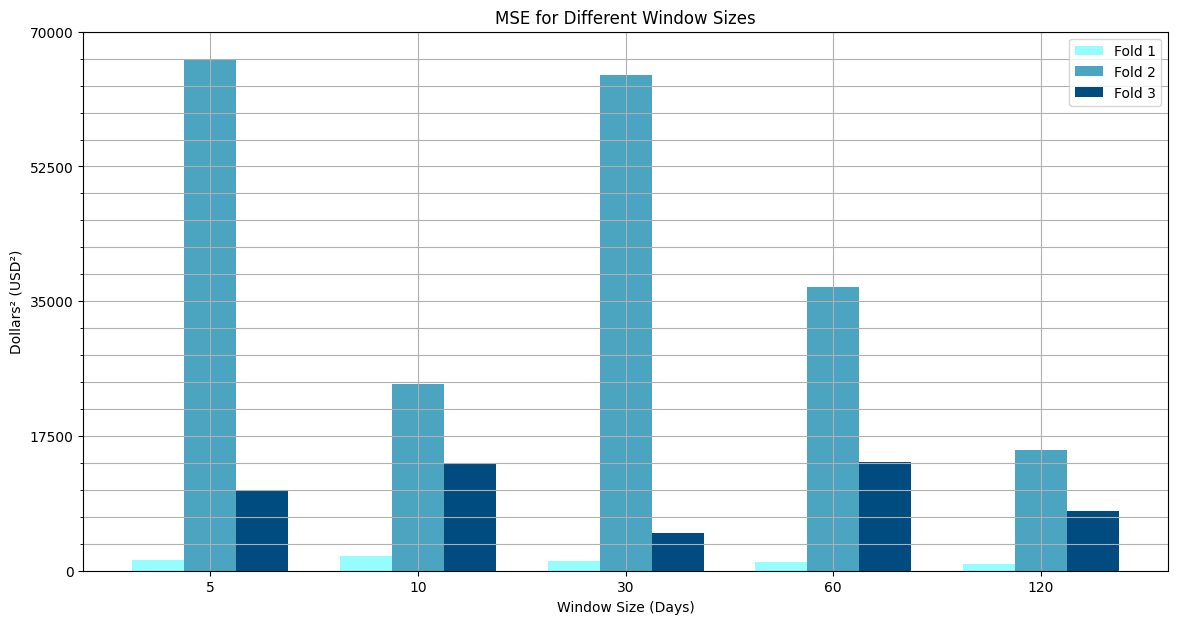

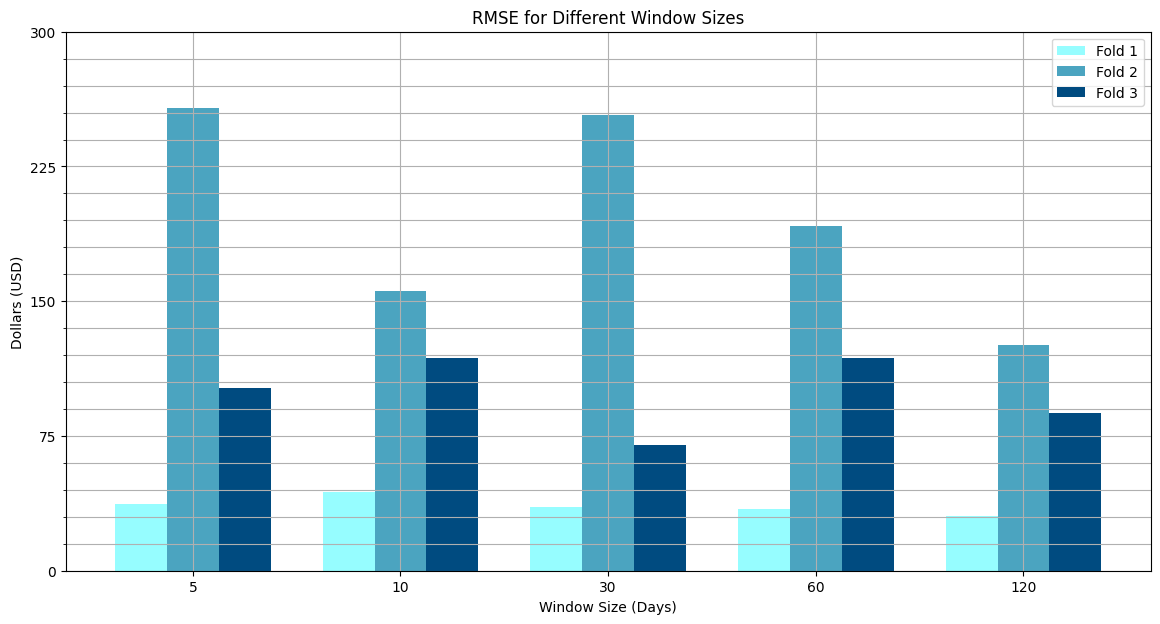

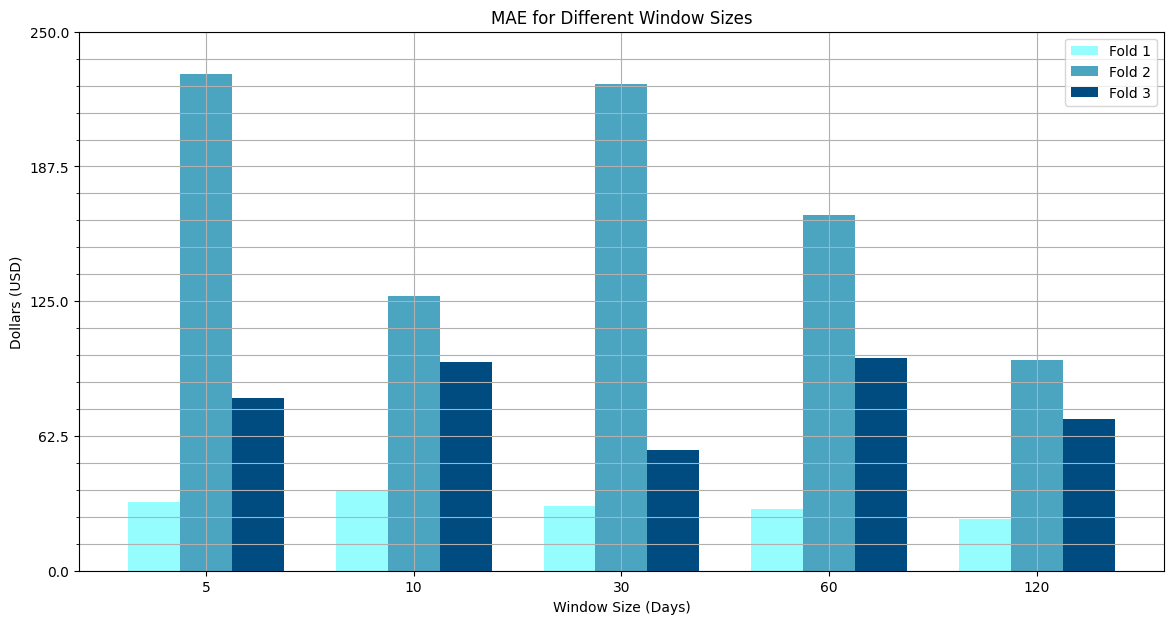

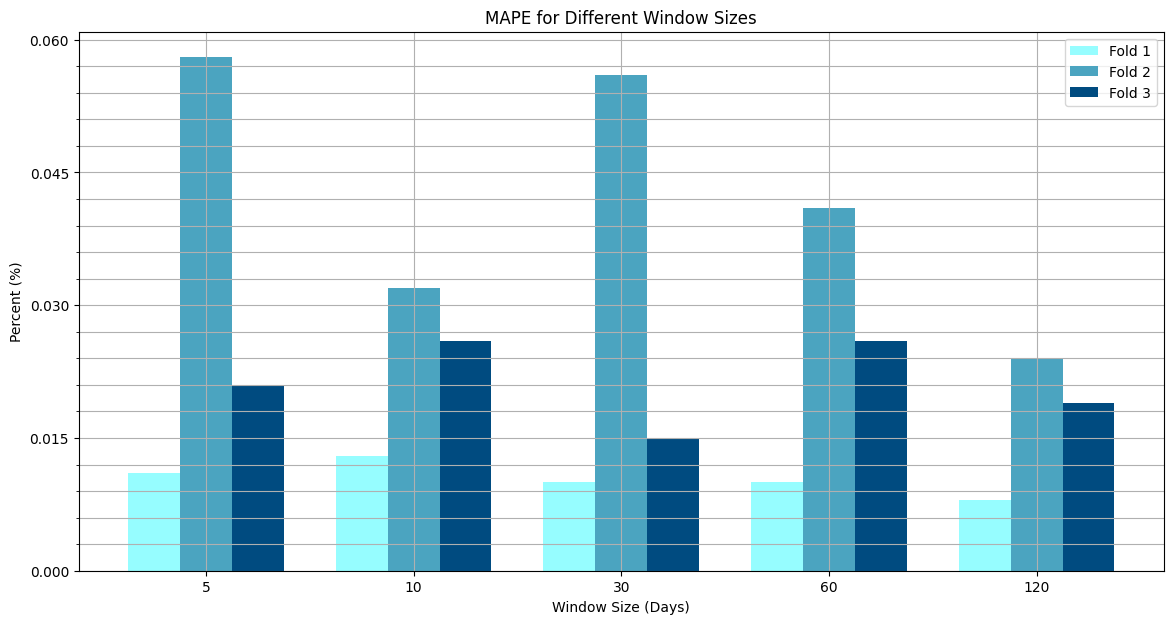

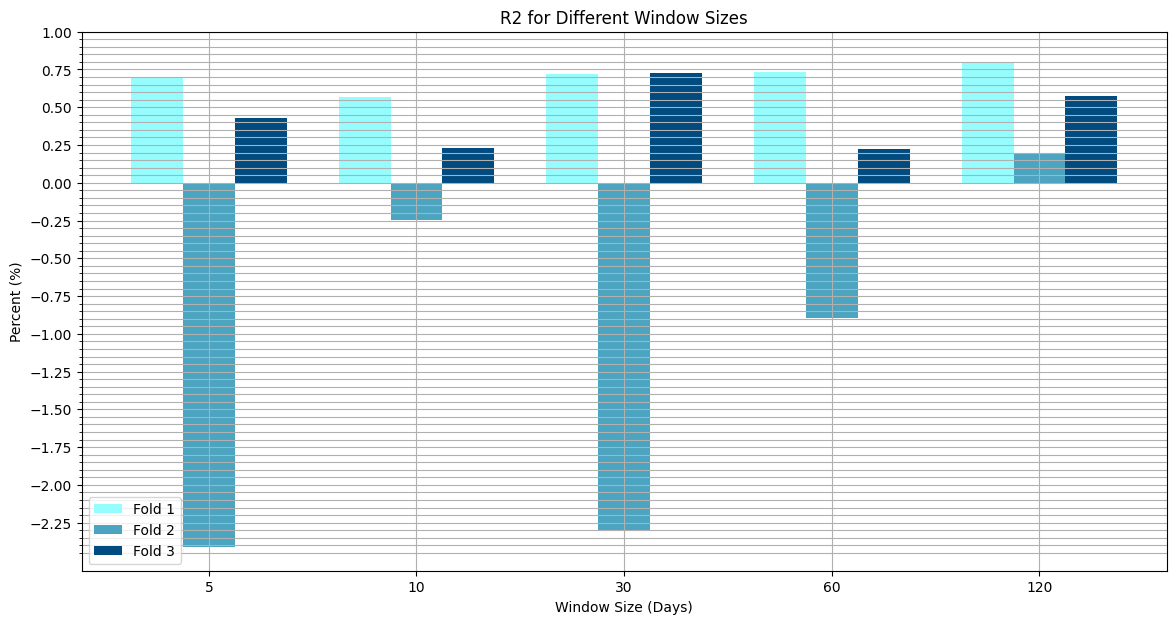

In [25]:
# Plotting the performance metrics for cross-validation
plot_performance_metrix(dict_performance_metrix_cv)